In [6]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
import os
import seaborn as sns; sns.set()
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from requests import get
from bs4 import BeautifulSoup
from pandas.util import hash_pandas_object

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
#Uncomment next line when u first use nltk and press download when all in selected on the windows of nltk downloads
#nltk.download()

import string
from ast import literal_eval
from tqdm import tqdm
#To detect language for stemming
# https://en.wikipedia.org/wiki/List_of_ISO_639-1_codes
#from langdetect import detect

## Import data

In [7]:
raw_data = pd.read_csv('data/en.openfoodfacts.org.products.csv', sep = '\t')

/home/bigbig/Anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (0,24,25,26,28,44,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### Drop columns not needed, explore missing values, and delete rows with zero or one value present

In [8]:
columns2keep = ['energy_100g','sugars_100g','saturated-fat_100g','sodium_100g',
    'fruits-vegetables-nuts_100g','fiber_100g','proteins_100g','nutrition-score-uk_100g',
    'nutrition_grade_fr','main_category_en','packaging','categories','labels_en',
    'pnns_groups_1','pnns_groups_2','product_name','ingredients_text']

In [9]:
data = raw_data[columns2keep]

In [10]:
data = data.replace("unknown",np.nan)

In [11]:
data = data.loc[(~data.isnull()).sum(axis=1)>1]

# FOOD CATEGORIES

In our first step, we aim to categorize products according to their Food Category. The PNNS ("Programme national nutrition santé" in French) aims at categorizing food in several major classes: Dairies, Composite, Fish Meat Eggs, Beverages, Fat Sauces, Fruits Vegetables, Starchy, and Snacks.

https://www.cerin.org/rapports/groupes-groupes-daliments/

### From pnns_groups_1 column

We map the given pnns categories to our 8 major ones

In [12]:
data["pnns_groups_1"].value_counts()

Sugary snacks              57026
Milk and dairy products    42882
Fish Meat Eggs             41840
Cereals and potatoes       33631
Beverages                  28908
Fat and sauces             27736
Composite foods            25029
Fruits and vegetables      24030
Salty snacks               19655
sugary-snacks               3453
fruits-and-vegetables       2865
cereals-and-potatoes          43
salty-snacks                   5
Name: pnns_groups_1, dtype: int64

In [13]:
# dictionnary to normalize category names into PNNS category
pnns1_category = {
 'Sugary snacks' : 'Snacks', 
 'Milk and dairy products' : 'Dairies',
 'Composite foods' : 'Composite', 
 'Cereals and potatoes' : 'Starchy', 
 'Fish Meat Eggs' : 'Fish Meat Eggs',
 'Beverages' : 'Beverages',
 'Fat and sauces' : 'Fat Sauces',
 'Fruits and vegetables' : 'Fruits Vegetables',
 'Salty snacks' : 'Snacks',
 'fruits-and-vegetables' : 'Fruits Vegetables',
 'sugary-snacks' : 'Snacks',
 'cereals-and-potatoes' : 'Starchy',
 'salty-snacks' : 'Snacks'
}
data.loc[:,'food_category'] = data['pnns_groups_1'].map(pnns1_category)

In [14]:
# New pnns categories
data["food_category"].value_counts()

Snacks               80139
Dairies              42882
Fish Meat Eggs       41840
Starchy              33674
Beverages            28908
Fat Sauces           27736
Fruits Vegetables    26895
Composite            25029
Name: food_category, dtype: int64

### From pnns_groups_2 column

We notice that several products haven't been categorized but have a non missing value in pnns_groups_2

In [15]:
# Values of pnns_groups_2 which haven't been classified in food_category
data.loc[data.food_category.isnull()]["pnns_groups_2"].value_counts()

Alcoholic beverages       9871
Pizza pies and quiches     398
Name: pnns_groups_2, dtype: int64

In [16]:
# dictionnary to extend food_categories from pnns_groups_2
pnns2_category = {
 'Pizza pies and quiches' : 'Composite', 
 'Alcoholic beverages' : 'Beverages',
}
data.loc[data.food_category.isnull(),'food_category'] = data.loc[data.food_category.isnull()]['pnns_groups_2'].map(pnns2_category)

In [17]:
data["food_category"].value_counts()

Snacks               80139
Dairies              42882
Fish Meat Eggs       41840
Beverages            38779
Starchy              33674
Fat Sauces           27736
Fruits Vegetables    26895
Composite            25427
Name: food_category, dtype: int64

### From main_category_en column

We complete our categorization with the help of the 'main_category_en' column

In [18]:
data.loc[data.food_category.isnull()]["main_category_en"].value_counts().head(30)

Beverages                          9266
Groceries                          5703
Plant-based foods and beverages    5098
Snacks                             3413
Dietary supplements                1939
Dairies                            1545
Baby foods                         1390
Desserts                           1272
Sweeteners                         1222
Cooking helpers                     739
Crêpes and galettes                 685
Food additives                      569
Non food products                   483
Canned foods                        477
Frozen foods                        445
Spreads                             392
Cocoa and chocolate powders         314
Licensed products                   306
Syrups                              285
Chips and fries                     238
fr:bloc-de-foie-gras-de-canard      229
es:bolleria-industrial              229
Pizza dough                         203
Banana-crisps                       197
Breakfasts                          196


In [19]:
# After inspecting the food type for the 30 most frequent values in main_category_en, we create the following dictionary
maincategoryen_category = {
'Beverages' : 'Beverages',
'Snacks' : 'Snacks',
'Dairies' : 'Dairies',
'Desserts' : 'Dairies',
'Crêpes and galettes' : 'Snacks',
'Cocoa and chocolate powders': 'Snacks',
'Syrups':'Fat Sauces',
'Chips and fries': 'Snacks',
'es:bolleria-industrial': 'Snacks',
'fr:bloc-de-foie-gras-de-canard': 'Fish Meat Eggs' ,
'Pizza dough' : 'Starchy',
'Breakfast' : 'Starchy',
'Banana-crisps' : "Snacks",
'Fish eggs' : 'Fish Meat Eggs',
'Terrines' : 'Fish Meat Eggs',
'fr:escalopes' : 'Fish Meat Eggs',
'Salads' : 'Fruits Vegetables',
'fr:pilons-de-poulet' : 'Fish Meat Eggs'
}

data.loc[data.food_category.isnull(),'food_category'] =  data.loc[data.food_category.isnull(),'main_category_en'].map(maincategoryen_category)

In [20]:
sum(data["food_category"].value_counts())/len(data)

0.3734660173241963

**After these steps, we managed to categorize 37% of our date among PNNS groups.**

For the unclassified data, the other columns don't bring any strong evidence for the categorization of the product. For instance, a lot of Dietary Supplements or Non Food Products are unclassified. Also, the table beneath shows that no column with above 10% completeness for uncategorized data gives us direct information on food categories.

In [21]:
completeness = raw_data.iloc[data[data.food_category.isnull()].index].count().sort_values(ascending=False)/len(data.loc[data.food_category.isnull()])
completeness.loc[completeness>0.1]

code                                       1.000000
states_en                                  1.000000
pnns_groups_1                              1.000000
pnns_groups_2                              1.000000
states                                     1.000000
states_tags                                1.000000
last_modified_datetime                     1.000000
last_modified_t                            1.000000
created_datetime                           1.000000
created_t                                  1.000000
creator                                    1.000000
url                                        1.000000
countries                                  0.998833
countries_en                               0.998833
countries_tags                             0.998833
product_name                               0.994132
energy_100g                                0.938649
proteins_100g                              0.935856
carbohydrates_100g                         0.933598
fat_100g    

In [22]:
classified_data = data.loc[~data.food_category.isnull()]
unclassified_data = data.loc[data.food_category.isnull()]

In [23]:
classified_data.loc[~classified_data.ingredients_text.isnull(),"ingredients_text"].count()/len(classified_data)

0.6366452603574596

40% of the remaining data has a list of ingredients, and 62% of our classified data also has a list of ingredients. We will use word similarities on the words in ingredient_text to associate unclassified products to categories if the similarity is big enough.

### Using Ingredients_text column 

In [24]:
# We clean the list of ingredients by removing punctuation and numbers

def clean_text(df,col):
    
    caracters2delete = ['%','-',':',',',"  ",'(',')',';','/','_','*','\d+','.','\'','[',']']

    df.loc[:,col] = df.loc[:,col].str.lower()
    for c in caracters2delete:
        df.loc[:,col] = df.loc[:,col].str.replace(c,' ')

    

clean_text(classified_data,"ingredients_text")
clean_text(unclassified_data,"ingredients_text")

/home/bigbig/Anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [25]:
# We compute the set of words for each category by keeping the 100 most frequent words that aren't stopWords

from collections import Counter
import nltk
from nltk.corpus import stopwords

# The dominant language in the ingredients in french
stopWords = stopwords.words('french') + ["kg","g","v","a","b","k","e","mg","and","of","ml","cl"]

def jaccard_similarity(list1, list2):
    s1 = set(list1) # gives the keys
    s2 = set(list2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

def createWordSet(df):   
    count = Counter([ word for sentence in df.loc[~df["ingredients_text"].isnull(),"ingredients_text"].tolist() for word in sentence.split(" ")[:5] if word not in stopWords])
    count[""] = 0
    n = sum(count.values())
    return dict([(word[0],word[1]/n) for word in count.most_common(100)])

category_words = classified_data.groupby("food_category").apply(createWordSet)
category_words["Beverages"]

{'eau': 0.08113946130131429,
 'jus': 0.05674995943533993,
 'sucre': 0.03525068959922116,
 'water': 0.02604251176375142,
 'gazéifiée': 0.01494807723511277,
 'malt': 0.014096219373681648,
 'orange': 0.014035372383579426,
 'orge': 0.01198685705013792,
 'pomme': 0.011510222294337173,
 'thé': 0.011429092974200876,
 'contient': 0.010293282492292714,
 'agua': 0.010212153172156417,
 'base': 0.009907918221645303,
 'juice': 0.009066201525231219,
 'wasser': 0.00888366055492455,
 'sulfites': 0.00841716696414084,
 'fruits': 0.008011520363459354,
 'source': 0.007889826383254908,
 'fructose': 0.007494320947590459,
 'sugar': 0.007179944832062308,
 'tea': 0.007129239006977122,
 'café': 0.00702782735680675,
 'sirop': 0.0066323219211423005,
 'carbonated': 0.006480204445886743,
 'vert': 0.00585145221483044,
 'minérale': 0.005831169884796365,
 'acidifiant': 0.00570947590459192,
 'purée': 0.005597923089404511,
 'vin': 0.005577640759370436,
 'naturelle': 0.005445805614148954,
 'filtered': 0.00499959435339931

The example shown above is the word dictionary for 'Beverages'. For each category we obtain a dictionary of the 100 most frequent words with normalized counts.

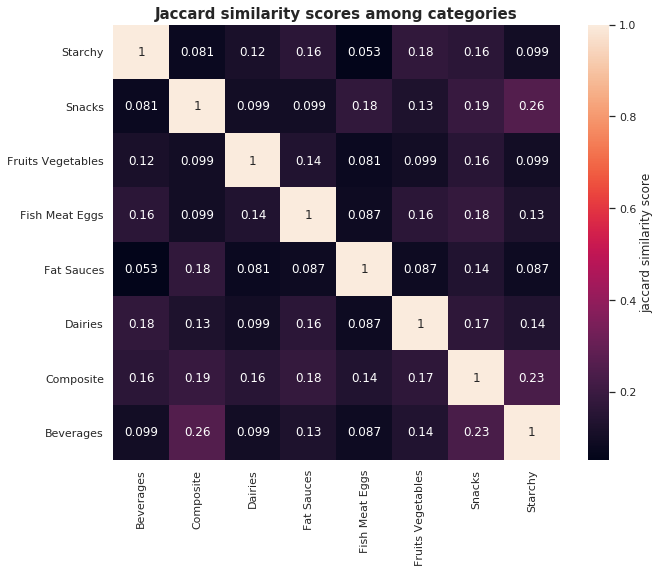

In [26]:
columns = category_words.index.values
n = len(columns)
similarity_matrix = np.zeros((n,n))

for idx1,name1 in enumerate(columns):
    for idx2,name2 in enumerate(columns):
        similarity_matrix[idx1,idx2] = jaccard_similarity(category_words[name1],category_words[name2])

plt.figure(figsize=(10,8))
sns.heatmap(similarity_matrix, annot=True, cbar_kws={'label': 'jaccard similarity score'})
plt.title("Jaccard similarity scores among categories", fontsize=15, fontweight="bold")
plt.xticks(np.arange(n)+0.5,columns,rotation='vertical')
plt.yticks(np.arange(n)+0.5,np.flip(columns,axis=0),rotation='horizontal')
plt.show()

We see that the dictionaries are rather distinct. The 'Composite' category shares words with other categories since it groups products from different food categories. We decide to drop 'Composite' for further categorization as it is too subjective to associate multiple categories to products with only the list of ingredients. We obtain more accurate results by associating only one category to products if the similarity is above an experimentally-set threshold.

In [27]:
category_words = category_words.drop("Composite")

In [28]:
# We split the unclassified data ingredient list in a list of non-stop words 

unclassified_data.loc[~unclassified_data.ingredients_text.isnull(),'ingredients_text'] = \
    unclassified_data.loc[~unclassified_data.ingredients_text.isnull(),'ingredients_text'] \
    .apply(lambda x: [word for word in x.split() if word not in stopWords])

To compute the similarity between a list of ingredients and a category, we compute a score. Each word in the list adds to the category score its importance in the category dictionary (normalized count in the dictionary) which is also weighted by its position in the ingredients list. The idea the ingredients of a product are listed in order of importance. We only consider the 10 first words in the ingredient list. We also divide the word score by the number of dictionaries it which it occurs. The ingredient is less representative of a food category if it also represents other categories.

We then categorize a product if its maximum similarity is above a 0.3 threshold. This threshold was set experimentally by manually looking up a product's information with its computed category.

In [29]:
intersections = dict();
for col in category_words.index.values:
    for word in set(category_words[col]):
        intersections[word] = intersections.get(word,0)+1


def similarity_dic(ingredients):
    dic = {}
    n = 10        
    for cat in category_words.index.values:
        score = 0
        for idx,word in enumerate(ingredients[:n]):
            score += category_words[cat].get(word,0)*(n-idx)/intersections.get(word,1)
        dic[cat] = score
    total = sum(dic.values())
    if (total != 0) :
        dic = {k: v / total for k, v in dic.items()}
    return dic

similarities = unclassified_data.loc[~unclassified_data.ingredients_text.isnull(),"ingredients_text"] \
            .apply(similarity_dic).apply(pd.Series)
    
# We remove products that have no similarities
similarities = similarities[(similarities.T != 0).any()]

similarities["category"] = similarities.loc[similarities.max(axis=1)>0.3].idxmax(axis=1)

# List some results with product_names
pd.concat([similarities,data.loc[similarities.index,"product_name"]], axis=1).head(20)

,Beverages,Dairies,Fat Sauces,Fish Meat Eggs,Fruits Vegetables,Snacks,Starchy,category,product_name
14,0.311089,0.080994,0.168972,0.313946,0.106911,0.013390,0.004699,Fish Meat Eggs,Solène céréales poulet
21,0.061252,0.613651,0.029158,0.001851,0.032022,0.230122,0.031944,Dairies,Crème dessert chocolat
28,0.083101,0.015129,0.055857,0.022975,0.036838,0.344948,0.441153,Starchy,Baguette Poitevin
37,0.057668,0.010001,0.045432,0.009513,0.032372,0.389654,0.455359,Starchy,Suedois saumon
41,0.141258,0.042288,0.289902,0.098148,0.327257,0.080117,0.021030,Fruits Vegetables,Salade shaker taboulé
42,0.079734,0.005554,0.437762,0.025260,0.055418,0.349005,0.047266,Fat Sauces,Banana Chips Sweetened (Whole)
43,0.015039,0.019693,0.042467,0.019860,0.023293,0.239316,0.640333,Starchy,Peanuts
47,0.146162,0.504582,0.088430,0.020313,0.039698,0.181422,0.019393,Dairies,Fromage blanc à la creme de marron
52,0.000000,0.000000,0.004388,0.000000,0.000000,0.452535,0.543077,Starchy,Sandwich solene céréales sicilien
93,0.079569,0.113937,0.280661,0.001633,0.166067,0.172831,0.185302,NaN,Organic Salted Nut Mix


We see that the categorization yields good results. Some products stay uncategorized by lack of dominant similarity but those who are appear to be well categorized with small errors (ex: Banana Chips Sweetened in row 44)

In [30]:
# We assign the new categroy values to those with missing categories
data.loc[data.food_category.isnull(),"food_category"] = similarities["category"]

sum(data["food_category"].value_counts())/len(data)

0.5873144828413993

The new number of categorized products represents 57% of the data kept.

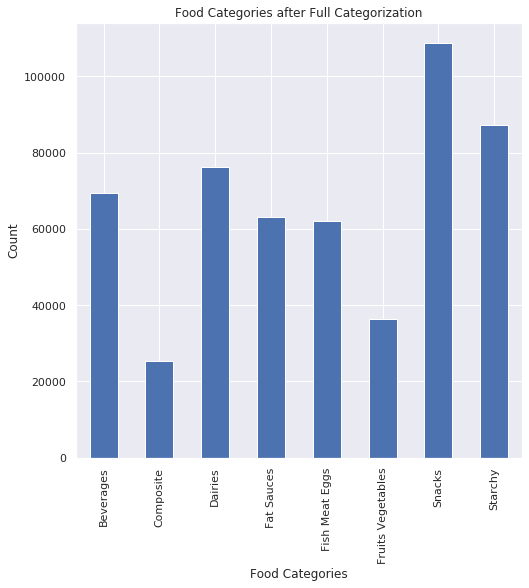

In [31]:
plt.figure(figsize=(8,8))
data.groupby("food_category").size().plot.bar()
plt.xlabel("Food Categories");
plt.ylabel("Count");
plt.title("Food Categories after Full Categorization");

# PACKAGING

While this field remains incomplete, it is still useful for us to analyze the packaging methods of different food categories. The processing pipeline for this field was performed as follows :
- clean 'Packaging' column of the dataframe by removing stop words and unecessary entries
- retain only certain material types of packaging (plastic, glass, cardboard, metal ...)
- plot the proportion of each material within a certain category of food

In [32]:
# We build our list of stopwords to remove when tockenizing the packaging column
stop_words_c = set(stopwords.words("french")).union(set(stopwords.words("english")))

# 'can' was removed since it was in the stop words list but still useful for Beverages containers
stop_words_c.remove('can')

In [33]:
# We clean the packaging column
def clean_data_packaging(data_column):
    """Clean data packaging, i.e. 
        - lower each words in the cells of data_column
        - tokenize cells of data_column, i.e. from float type create list of string (token)
        - remove stopwords for the list of tokens for each cells of data_column
    """  
    
    tokenizer = RegexpTokenizer(r'\w+')
    data_column = data_column[data_column.notnull()].str.lower() \
    .apply(str) \
    .apply(tokenizer.tokenize) \
    .apply(lambda cell : [item for item in cell if item not in stop_words_c]) \
    .apply(str)
    
    return data_column


packaging = clean_data_packaging(data.packaging)
packaging = packaging.apply(literal_eval)
filled_pck = data.packaging.count()/len(data.packaging)

# We visualize some results
print(f'Packaging field is full at {filled_pck} %')
packaging.head()

Packaging field is full at 0.20818598282695142 %


15     [barquette, plastique]
138        [bocal, plastique]
142               [plastique]
294       [carton, plastique]
295       [plastique, carton]
Name: packaging, dtype: object

**20% of the data has packaging information**
We now categorize the packaging information to defined packaging classes.

In [34]:
# Vaccum items were added since it surely contains plastic
plastique_words = ['plastic', 'plastique', 'plastik', 'plastico', 'plastica', 'sachets', 
                   'plàstic', 'plástico', 'plastisco' ,'bucket', 'barquette', 'sachet', 'tube', 'film', 'vacio', 'vide', 'vacío']

verre_words = ['verre', 'glass', 'glas', 'vidrio', 'pot']
carton_words = ['paper', 'karton', 'carton', 'papier', 'boite', 'cartón', 'papel', 'cardboard', 
                'card', 'eggbox', 'box']

metal_words = ['metal', 'métal', 'fer', 'acier', 'aluminium', 'can', 'canette', 'conserve','tin']

# Fresh products needs an adapted container which is useful for further exploration
prod_frais_words = ['frais', 'fresh', 'frai']

# The recycable materials depend on the country and regulations. However, these materials are commonly recycable.
# (soiled papers, soiled metalic containers and soiled plastic containers tend to be avoided for medical reasons)
recyclable_words = ['bouteille', 'flacon', 'brique', 'brick', 'bottle', 'bte', 'verre', 
                    'glass', 'glas', 'vidrio', 'metal', 'métal', 'fer', 'acier', 'aluminium', 'flasche', 'canned', 
                    'can', 'canette', 'conserve', 'tin', 'pet', 'pot', 'botella']

def count_entries(self, word_list):
    """ Return true if word_list and self have a word in common,
        else o/w.
    """
    if len(set(self).intersection(set(word_list))) > 0:
        return True
    else :
        return False

def to_materials(elem):
    """ Return a list of bool that informs about the materials used 
        for the packaging.
    """
    return [count_entries(elem, plastique_words), 
               count_entries(elem, verre_words), 
               count_entries(elem, carton_words),
               count_entries(elem, metal_words),
               count_entries(elem, prod_frais_words),
               count_entries(elem, recyclable_words)]
    

In [35]:
# We a create a boolean list for each value representing the membership to packaging methods and fresh/recycable attribute
materials_df = pd.DataFrame({'Packaging': packaging, 'materials':pd.Series(np.zeros(len(packaging)), packaging.index)})
materials_df['materials'] = packaging.apply(to_materials)

In [36]:
# We create a dataframe with the information
names_list = ['Plastic', 'Glass', 'Carton', 'Metal', 'Fresh', 'Recyclable']
materials_df = materials_df.materials.apply(pd.Series)
materials_df = materials_df.rename(columns = lambda x : names_list[x])

In [37]:
# We merge with the food categories
eco_impact_plot_df = materials_df.merge(data.loc[materials_df.index.tolist(), ["food_category"]], left_index = True, right_index = True)

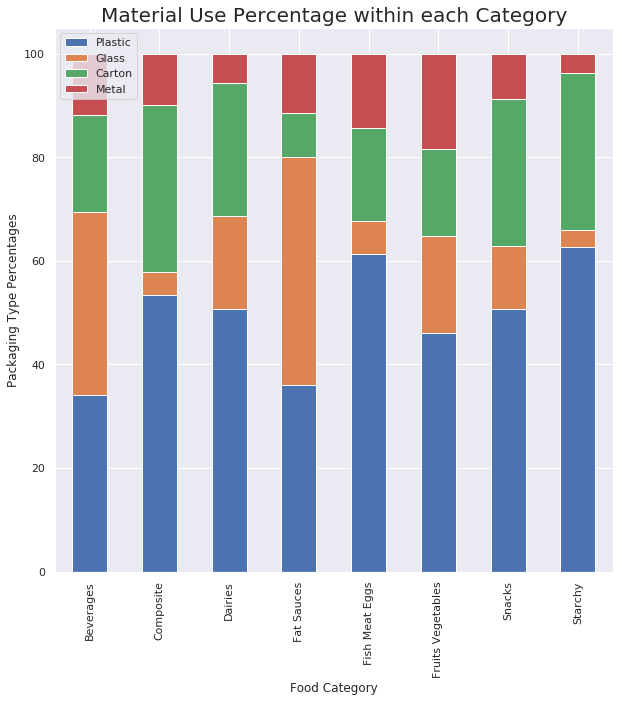

In [38]:
# We remove Fresh and Recycable categories and plot normalized bar plots for the packaging for each food category
packaging_plot_df = eco_impact_plot_df.drop('Fresh', axis =1)
packaging_plot_df = packaging_plot_df.drop('Recyclable', axis =1)
counts_pack = packaging_plot_df.groupby('food_category').sum()

plt.figure(figsize =(10,10))
ax=plt.gca()
counts_pack.div(counts_pack.sum(axis=1)/100, axis = 0).plot.bar(ax=ax, stacked=True)
plt.title('Material Use Percentage within each Category',fontsize=20);
plt.xlabel("Food Category");
plt.ylabel("Packaging Type Percentages");

While the sample size is limited, a few useful informations are depicted on the above plot. First we can see that a lot of plastic is used among every category. Moreover, glass is mainly used as a liquid container which is consistent with what we could expect. The packaging information along with the use of cooling containers and recyclability of products will be used in the analysis of different diets.

### DIET from labels_en

In [39]:
regimes = ['isVegetarian', 'isVegetalian', 'isGlutenfree', 'isLactosefree', 'isKetogenic', 'isOrganic']

In [40]:
def clean_caract(df,col):
    
    caracters2delete = ['%',':','(',')',';','/','_','*','\d+','.','\'','[',']']

    df.loc[:,col] = df.loc[:,col].str.lower()
    for c in caracters2delete:
        df.loc[:,col] = df.loc[:,col].str.replace(c,' ')


In [41]:
data["split_labels_en"] = data["labels_en"]
clean_caract(data,"split_labels_en")
data.loc[:,"split_labels_en"] = data.loc[:,"split_labels_en"].str.split(',')


In [42]:
is_vegetarian_list = ['vegetarian']
not_vegetarian_list = ['meat']
data["isVGT"] = data.loc[~data["split_labels_en"].isnull(),"split_labels_en"] \
.apply(lambda l : bool(~any([cat_word in not_vegetarian_list for cat_word in l]) &  \
                       any([cat_word in is_vegetarian_list for cat_word in l])))

is_vegetalian_list = ['vegan']
not_vegetalian_list = ['meat']
data["isVGL"] = data.loc[~data["split_labels_en"].isnull(),"split_labels_en"] \
.apply(lambda l : bool(~any([cat_word in not_vegetalian_list for cat_word in l]) &  \
                       any([cat_word in is_vegetalian_list for cat_word in l])))

is_glutenfree_list = ['gluten-free']
not_glutenfree_list = ['mais']
data["isGF"] = data.loc[~data["split_labels_en"].isnull(),"split_labels_en"] \
.apply(lambda l : bool(~any([cat_word in not_glutenfree_list for cat_word in l]) &  \
                       any([cat_word in is_glutenfree_list for cat_word in l])))

is_lactosefree_list = ['no lactose']
not_lactosefree_list = ['lait']
data["isLF"] = data.loc[~data["split_labels_en"].isnull(),"split_labels_en"] \
.apply(lambda l : bool(~any([cat_word in not_lactosefree_list for cat_word in l]) &  \
                       any([cat_word in is_lactosefree_list for cat_word in l])))

is_organic_list = ['organic','eu organic','fr ab-agriculture-biologique']
not_organic_list = ['non organic']
data["isOG"] = data.loc[~data["split_labels_en"].isnull(),"split_labels_en"] \
.apply(lambda l : bool(~any([cat_word in not_organic_list for cat_word in l]) &  \
                       any([cat_word in is_organic_list for cat_word in l])))

In [43]:
len(data[data["isVGT"]==True])

17602

In [44]:
len(data[data["isVGL"]==True])

14922

In [45]:
len(data[data["isGF"]==True])

26981

In [46]:
len(data[data["isLF"]==True])

5946

In [47]:
len(data[data["isOG"]==True])

64570

In [48]:
# almost all vegetalian are in vegetarian
len(data[(data["isVGL"]==True) & (data["isVGT"]==True)])/len(data[(data["isVGT"]==True)])

0.8477445744801727

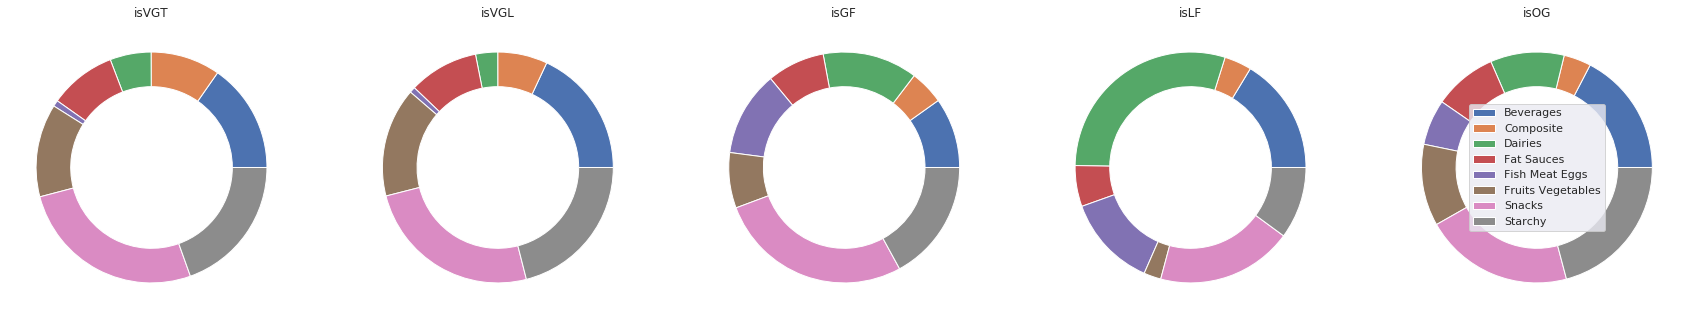

In [111]:
# create data
diets_data = data[['food_category', 'isVGT', 'isVGL', 'isGF', 'isLF', 'isOG']]
diets_plot = diets_data.groupby('food_category').sum()

# Create a pieplot
fig, axes = plt.subplots(1,5, figsize=(30,20))
for ax, col in zip(axes, diets_data.columns[1:]):
    ax.pie(diets_plot[col], wedgeprops=dict(width=.3))
    ax.set(ylabel='', title=col, aspect='equal')
plt.legend(diets_plot.index, loc='center')
plt.show()

In [112]:
diets_data.index

Int64Index([      0,       2,       3,       4,       8,       9,      12,
                 13,      14,      15,
            ...
            1024761, 1024762, 1024763, 1024764, 1024765, 1024766, 1024767,
            1024768, 1024769, 1024770],
           dtype='int64', length=899782)

## Diet from ingredients

In [113]:
carnivore_list = [
    'animal','animals',
    #viande
    'viande','viandes','meat','fleisch','carne',
    'bœuf','boeuf','boeufs','beef','steak','vache','cow', 'bovin','bovine',
    'charcut', 'charcuteries', 'charcuterie',
    'poulet','poulets','poule','poules','chicken','volaille','volailles',
    'porc','pork','jambons', 'jambon', 'jam','cerdo','lardon','lardons','bacon','schweinefleisch',
    'cannard','canard',
    'dinde','dindes', 'turkey',
    'boudin','foie','rillette','rillettes','couenne',
    'poitrine','cuisse','cuisses'
    'chipolata','chipolatas',
    'brebis', 'mouton'
    #poisson
    'poisson','fish', 'fisch',
    'sardine','sardines','sardina',
    'thon','thuna','tuna',
    'saumon','salmon', 'salmo'
    'hareng', 'seafood',
    'maquereaux','cabillaud','morue',
    'crevettes', 'shrimp',
    'albacore','colin','truite','moules'
]


In [114]:
# Words which reference water
#carnivore_list = ["viande"]

# Some 'categories' values contain words refering to water but are liquors
# We thus create a list to discard such products
soja_list = ["soja"]

# We clean the 'categories' column and split into words
data["split_ingredients_text"] = data["ingredients_text"]
clean_text(data,"ingredients_text")
data.loc[:,"split_ingredients_text"] = data.loc[:,"split_ingredients_text"].str.split()
#
#data["iscarnivore"] = data.loc[~data["split_ingredients_text"].isnull(),"split_ingredients_text"] \
#.apply(lambda l : bool(~any([cat_word in soja_list for cat_word in l]) &  \
#                       any([cat_word in carnivore_list for cat_word in l])))

In [115]:
data["iscarnivore"] = data.loc[~data["split_ingredients_text"].isnull(),"split_ingredients_text"] \
.apply(lambda l : bool(any([cat_word in carnivore_list for cat_word in l])))

In [116]:
data["iscarnivore"].value_counts()

False    380408
True      67447
Name: iscarnivore, dtype: int64

# NUTRISCORE
https://quoidansmonassiette.fr/comment-est-calcule-le-nutri-score-logo-nutritionnel/

We calculate the nutriscore according to the method described in the link above.

### Water Tag
In order to compute the NutriScore (NS) of products, we need to seperate water from other beverages.

In [117]:
# Words which reference water
water_list = ["water","waters","eau","agua"]

# Some 'categories' values contain words refering to water but are liquors
# We thus create a list to discard such products
nonwater_list = ["alkoholische","alcoholic","spirits","liquors","tonic",'coconut','sodas','soda']

# We clean the 'categories' column and split into words
data["split_categories"] = data["categories"]
clean_text(data,"split_categories")
data.loc[:,"split_categories"] = data.loc[:,"split_categories"].str.split()

data["iswater"] = data.loc[~data["split_categories"].isnull(),"split_categories"] \
.apply(lambda l : bool(~any([cat_word in nonwater_list for cat_word in l]) &  \
                       any([cat_word in water_list for cat_word in l])))




In [118]:
data[data["iswater"]==True][['product_name','split_categories']]

,product_name,split_categories
14260,Pure Water,"[beverages, waters, unsweetened, beverages]"
16573,Black raspberry naturally flavoured sparkling ...,"[beverages, carbonated, drinks, waters, carbon..."
20972,Drinking Water,"[beverages, waters]"
20973,refreshe drinking water,"[beverages, waters, drinking, water, unsweeten..."
23848,NaN,"[natural, spring, water]"
27111,Orange Blossom Water,"[orange, blossom, water]"
27112,Rose Water,"[rose, water]"
28361,Kirkland Drinking Water,"[beverages, waters, unsweetened, beverages]"
40249,Drinking Water,"[en, drinking, water]"
53777,Coconut walter with chocolate,"[agua, de, coco]"


In [119]:
data.loc[12674,'split_categories']

nan

In [120]:
data["iswater"].value_counts()

False    376909
True        770
Name: iswater, dtype: int64

### Data Setup

In [121]:
# replace NaN of 'fruits-vegetables-nuts_100g' by 100 if it is 'Fruit juices'
data[(data['main_category_en'] == 'Fruit juices')]['fruits-vegetables-nuts_100g'].fillna(0, inplace=True)

/home/bigbig/Anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [122]:
selected_fields =[
    'product_name','food_category',
    'energy_100g','sugars_100g','saturated-fat_100g','sodium_100g',
    'fruits-vegetables-nuts_100g',
    'fiber_100g','proteins_100g',
    'nutrition-score-uk_100g',
    'nutrition_grade_fr',
    'iswater']

In [123]:
# divide dataframe into 3 groups to simplify the calculation of nutriscrore
data_beverages = data[data['food_category']=='Beverages'][selected_fields]
data_fatsauces = data[data['food_category']=='Fat Sauces'][selected_fields]
data_without_beverage_fat = data[(data['food_category']!='Fat Sauces') & (data['food_category']!='Beverages') ][selected_fields]                    

### Calculation of negative points

We attribute Negative points (N) to different nutritional factors that have to be limited: energy, sugar, saturated fat and sodium

In [124]:
## ENERGY
# energy bins
energy_bins_without_beverage_fat = [data_without_beverage_fat['energy_100g'].min() - 1, 335, 670, 1005, 1340, 1675, 2010, 2345, 2680, 3015, 3350, data_without_beverage_fat['energy_100g'].max()]
energy_bins_fatsauces = [data_fatsauces['energy_100g'].min() - 1, 335, 670, 1005, 1340, 1675, 2010, 2345, 2680, 3015, 3350, data_fatsauces['energy_100g'].max()]
energy_bins_beverages = [data_beverages['energy_100g'].min() - 1, 0, 30, 60, 90, 120, 150, 180, 210, 240, 270, data_beverages['energy_100g'].max()]
# energy point
data_without_beverage_fat['energy_points'] = pd.cut(data_without_beverage_fat['energy_100g'], energy_bins_without_beverage_fat, labels=range(11)).astype(float)
data_fatsauces['energy_points'] = pd.cut(data_fatsauces['energy_100g'], energy_bins_fatsauces, labels=range(11)).astype(float)
data_beverages['energy_points'] = pd.cut(data_beverages['energy_100g'], energy_bins_beverages, labels=range(11)).astype(float)


## SUGAR
# sugar bins
sugar_bins_without_beverage_fat = [data_without_beverage_fat['sugars_100g'].min() - 1, 0, 1.5, 3, 4.5, 6, 7.5, 9, 10.5, 12, 13.5, data_without_beverage_fat['sugars_100g'].max()]
sugar_bins_fatsauces = [data_fatsauces['sugars_100g'].min() - 1, 0, 1.5, 3, 4.5, 6, 7.5, 9, 10.5, 12, 13.5, data_fatsauces['sugars_100g'].max()]
sugar_bins_beverages = [data_beverages['sugars_100g'].min() - 1, 4.5, 9, 13.5, 18, 22.5, 27, 31, 36, 40, 45, data_beverages['sugars_100g'].max()]
# sugar point (CHANGE SUGAR_BINS)
data_without_beverage_fat['sugar_points'] = pd.cut(data_without_beverage_fat['sugars_100g'], sugar_bins_without_beverage_fat, labels=range(11)).astype(float)
data_fatsauces['sugar_points'] = pd.cut(data_fatsauces['sugars_100g'], sugar_bins_fatsauces, labels=range(11)).astype(float)
data_beverages['sugar_points'] = pd.cut(data_beverages['sugars_100g'], sugar_bins_beverages, labels=range(11)).astype(float)


## SATURATED FAT
# s-fat bins
fat_bins_without_beverage_fat = [data_without_beverage_fat['saturated-fat_100g'].min() - 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, data_without_beverage_fat['saturated-fat_100g'].max()]
fat_bins_beverages = [data_beverages['saturated-fat_100g'].min() - 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, data_beverages['saturated-fat_100g'].max()]
fat_bins_fatsauces = [data_fatsauces['saturated-fat_100g'].min() - 1, 10, 16, 22, 28, 34, 40, 46, 52, 58, 64, data_fatsauces['saturated-fat_100g'].max()]
# s-FAT point (CHANGE FAT_BINS)
data_without_beverage_fat['saturated-fat_points'] = pd.cut(data_without_beverage_fat['saturated-fat_100g'], fat_bins_without_beverage_fat, labels=range(11)).astype(float)
data_beverages['saturated-fat_points'] = pd.cut(data_beverages['saturated-fat_100g'], fat_bins_beverages, labels=range(11)).astype(float)
data_fatsauces['saturated-fat_points'] = pd.cut(data_fatsauces['saturated-fat_100g'], fat_bins_fatsauces, labels=range(11)).astype(float)


## SODIUM
# sodium bins
sodium_bins = [data['sodium_100g'].min() - 1, 90, 180, 270, 360, 450, 540, 630, 720, 810, 900, data['sodium_100g'].max()]
# sodium points
data_without_beverage_fat['sodium_points'] = pd.cut(data_without_beverage_fat['sodium_100g'], sodium_bins, labels=range(11)).astype(float)
data_beverages['sodium_points'] = pd.cut(data_beverages['sodium_100g'], sodium_bins, labels=range(11)).astype(float)
data_fatsauces['sodium_points'] = pd.cut(data_fatsauces['sodium_100g'], sodium_bins, labels=range(11)).astype(float)



### Calculation positive points

We attribute Positive points (P) to different nutritional factors that have to be promoted: fruit vegetable nuts pourcentage, fibers and proteins.

In [125]:
# FRUITS
# fruits bins
fruits_bins_without_beverage_fat = [data_without_beverage_fat['fruits-vegetables-nuts_100g'].min() - 1, 40, 60, 80, data_without_beverage_fat['fruits-vegetables-nuts_100g'].max()]
fruits_bins_fatsauces = [data_fatsauces['fruits-vegetables-nuts_100g'].min() - 1, 40, 60, 80, data_fatsauces['fruits-vegetables-nuts_100g'].max()]
fruits_bins_beverages = [data_beverages['fruits-vegetables-nuts_100g'].min() - 1, 40, 60, 80, data_beverages['fruits-vegetables-nuts_100g'].max()]
# fruits points
data_without_beverage_fat['fruits_points'] = pd.cut(data_without_beverage_fat['fruits-vegetables-nuts_100g'], fruits_bins_without_beverage_fat, labels=[0,1,2,5]).astype(float)
data_beverages['fruits_points'] = pd.cut(data_beverages['fruits-vegetables-nuts_100g'], fruits_bins_beverages, labels=[0,2,4,10]).astype(float)
data_fatsauces['fruits_points'] = pd.cut(data_fatsauces['fruits-vegetables-nuts_100g'], fruits_bins_fatsauces, labels=[0,1,2,5]).astype(float)


# FIBRES
# fibers bins
fibers_bins = [data['fiber_100g'].min() - 1, 0.7, 1.4, 2.1, 2.8, 3.5, data['fiber_100g'].max()]
# fibers points
data_without_beverage_fat['fiber_points'] = pd.cut(data_without_beverage_fat['fiber_100g'], fibers_bins, labels=range(6)).astype(float)
data_beverages['fiber_points'] = pd.cut(data_beverages['fiber_100g'], fibers_bins, labels=range(6)).astype(float)
data_fatsauces['fiber_points'] = pd.cut(data_fatsauces['fiber_100g'], fibers_bins, labels=range(6)).astype(float)

# PROTEINS
# proteins bins
proteins_bins = [data['proteins_100g'].min() - 1, 1.6, 3.2, 4.8, 6.4, 8.0, data['proteins_100g'].max()]
# proteins points
data_without_beverage_fat['proteins_points'] = pd.cut(data_without_beverage_fat['proteins_100g'], proteins_bins, labels=range(6)).astype(float)
data_beverages['proteins_points'] = pd.cut(data_beverages['proteins_100g'], proteins_bins, labels=range(6)).astype(float)
data_fatsauces['proteins_points'] = pd.cut(data_fatsauces['proteins_100g'], proteins_bins, labels=range(6)).astype(float)


In [126]:
# rejoin last separated dataframe
frames = [data_without_beverage_fat, data_beverages, data_fatsauces]
nutridata = pd.concat(frames)

### Nutriscore calculation

In [127]:
# concession made to put 0 inplace of Nan of 'fruits_points','fiber_points','proteins_points' 
# this will not be a problem we do not substract Positive point
nutridata['fruits_points'] = nutridata['fruits_points'].fillna(0)
nutridata['fiber_points'] = nutridata['fiber_points'].fillna(0)
nutridata['proteins_points'] = nutridata['proteins_points'].fillna(0)

In [128]:
# calculation of P x N
nutridata['points_N']= nutridata['energy_points'] + nutridata['saturated-fat_points'] + nutridata['sugar_points'] + nutridata['sodium_points']
nutridata['points_P'] = nutridata['fruits_points'] + nutridata['fiber_points'] + nutridata['proteins_points']

In [129]:
def compute_score(row):
    N = row['points_N']
    P = row['points_P']
    fruit = row['fruits_points']
    fiber = row['fiber_points']
        
    if N < 11 or fruit == 5:
        return N - P
    else:
        return N - (fiber + fruit)
    
nutridata['nutri-score_calculated'] = nutridata.apply(compute_score, axis=1)

### Convertion of NutriScore into NutriLetter


In [130]:
# re divided dataframe to allow a simpler transformation of score into letter
nutridata_beverages = nutridata[ (nutridata['food_category']=='Beverages') & (nutridata['iswater']!=True)]
nutridata_not_beverages = nutridata[ nutridata['food_category']!='Beverages']
nutridata_beverages_water = nutridata[ (nutridata['food_category']=='Beverages') & (nutridata['iswater']==True)]

In [131]:
# NUTRILETTER

#letter bins
letter_bins_aliments = [nutridata['nutri-score_calculated'].min() - 1, 0, 2.9, 10.9, 18.9, nutridata['nutri-score_calculated'].max()]
letter_bins_beverages = [nutridata['nutri-score_calculated'].min() - 1, 2.5, 5.5, 9.5, nutridata['nutri-score_calculated'].max()]
letter_bins_beverages_water = [nutridata['nutri-score_calculated'].min() - 1, nutridata['nutri-score_calculated'].max()]

#letter
nutridata_not_beverages['nutri-score_letter_CALCULATED'] = pd.cut(nutridata_not_beverages['nutri-score_calculated'], letter_bins_aliments, labels=['a','b','c','d','e'])
nutridata_beverages['nutri-score_letter_CALCULATED'] = pd.cut(nutridata_beverages['nutri-score_calculated'], letter_bins_beverages, labels=['b','c','d','e'])
nutridata_beverages_water['nutri-score_letter_CALCULATED'] = pd.cut(nutridata_beverages_water['nutri-score_calculated'], letter_bins_beverages_water, labels=['a'])


/home/bigbig/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/bigbig/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/home/bigbig/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [132]:
nutriframes = [nutridata_not_beverages, nutridata_beverages, nutridata_beverages_water]
nutridata = pd.concat(nutriframes)

nutridata['nutri-score_letter_CALCULATED'].value_counts().sum()

760104

At the end of this process of NS calculation we obtain a NS for 770k product that represent almost 80% our the entire dataset

### Visualisation of proportion of NutriLetter label for each Food Category

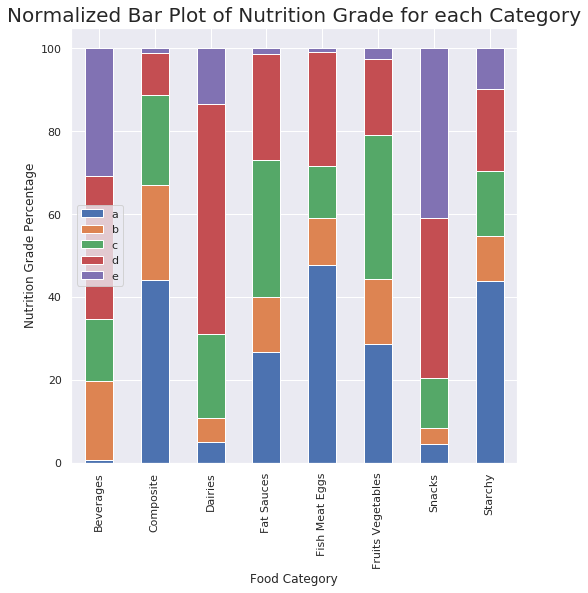

In [133]:
lettercounts =nutridata.groupby(['food_category','nutri-score_letter_CALCULATED']).count()['nutri-score_calculated']

plt.figure(figsize=(8,8))
ax=plt.gca()

lettercounts.unstack().div(lettercounts.unstack().sum(axis=1)/100,axis=0).plot.bar(ax=ax,stacked=True)
plt.legend(loc='center left')
plt.title("Normalized Bar Plot of Nutrition Grade for each Category",fontsize=20);
plt.xlabel("Food Category");
plt.ylabel("Nutrition Grade Percentage");

## comparation nutriletter rawdata vs calculated

In [134]:
product_2nutriletter =len(nutridata[(nutridata['nutri-score_letter_CALCULATED'].notnull()) & (nutridata['nutrition_grade_fr'].notnull())])
product_2nutriletter

289076

In [135]:
product_samenutriletter =len(nutridata[(nutridata['nutri-score_letter_CALCULATED'].notnull()) & (nutridata['nutrition_grade_fr'].notnull()) & (nutridata['nutri-score_letter_CALCULATED']==nutridata['nutrition_grade_fr'])])
product_samenutriletter             
              

132703

In [137]:
nutri_df = nutridata[(nutridata['nutri-score_letter_CALCULATED'].notnull()) & (nutridata['nutrition_grade_fr'].notnull()) & (nutridata['nutri-score_letter_CALCULATED']!=nutridata['nutrition_grade_fr'])][['product_name','food_category','nutrition_grade_fr','nutri-score_letter_CALCULATED']]

In [140]:
nutri_df.head(10)

,product_name,food_category,nutrition_grade_fr,nutri-score_letter_CALCULATED
8,Salade de carottes râpées,Composite,b,c
15,Tarte noix de coco,Snacks,d,e
23,Compote de poire,Fruits Vegetables,a,c
50,cuisse de poulet direct au four curry,Fish Meat Eggs,c,b
51,Bagel,Starchy,b,a
56,Pavé de saumon fumé à la ficelle,Fish Meat Eggs,d,b
58,CORNED BEEF,NaN,d,c
294,Blanquette de Volaille et son Riz,Composite,b,a
295,Raviolini au Fromage de chèvre et Pesto,Composite,b,a
297,Salade Cesar,Fruits Vegetables,a,b


In [142]:
nutri_df['NG_fr'] = pd.factorize(nutri_df['nutrition_grade_fr'], sort=True)[0] + 1
nutri_df['NG_calc'] = pd.factorize(nutri_df['nutri-score_letter_CALCULATED'], sort=True)[0] + 1

In [144]:
nutri_df['Diff'] = (nutri_df['NG_fr'] - nutri_df['NG_calc']).abs()

In [151]:
nutri_df.head(10)

,product_name,food_category,nutrition_grade_fr,nutri-score_letter_CALCULATED,NG_fr,NG_calc,Diff
8,Salade de carottes râpées,Composite,b,c,2,3,1
15,Tarte noix de coco,Snacks,d,e,4,5,1
23,Compote de poire,Fruits Vegetables,a,c,1,3,2
50,cuisse de poulet direct au four curry,Fish Meat Eggs,c,b,3,2,1
51,Bagel,Starchy,b,a,2,1,1
56,Pavé de saumon fumé à la ficelle,Fish Meat Eggs,d,b,4,2,2
58,CORNED BEEF,NaN,d,c,4,3,1
294,Blanquette de Volaille et son Riz,Composite,b,a,2,1,1
295,Raviolini au Fromage de chèvre et Pesto,Composite,b,a,2,1,1
297,Salade Cesar,Fruits Vegetables,a,b,1,2,1


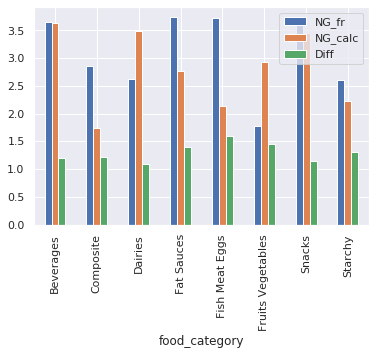

In [150]:
nutri_df.drop(['product_name', 'nutrition_grade_fr', 'nutri-score_letter_CALCULATED'], axis = 1).groupby('food_category').mean().plot(kind='bar')

# Diet Study 



### Helper functions for Diet Study

In [8]:
def clean_data(data, column_to_clean, stop_words, tokenizer, wordnet_lemmatizer, tok_gaps=False, saving=False, langdetec=False, tokenize=False, stemming=False, lemmatizing=False, onlyEngStemmer=False, onlyFrStemmer=False, applyNounFilter=False):
    """function that appeals all cleaning methods depending of the booleans"""
    cleaned_data = pd.DataFrame()    
    cleaned_data[column_to_clean] = data[column_to_clean].copy()
    
    
    if langdetec:
        cleaned_data["languages"] = data[data[column_to_clean].notnull()][column_to_clean].apply(language_detection)
        #I found all the languages disponibles for stemming, and i map the corresponding name to the ISO_code found by langdetect.detect
        cleaned_data["languages"] = cleaned_data["languages"].map({"ar": "arabic", "da": "danish", "nl" : "dutch", "en": "english", "fi": "finnish", "fr": "french", "de": "german", \
                                  "hu": "hungarian", "it": "italian", "no": "norwegian", "ro": "romanian", "ru" : "russian", "es": "spanish", \
                                  "sv" :"swedish"})
        if saving:
            cleaned_data.to_pickle("exploration/processed_pickle/"+str(column_to_clean)+"/out_langdetect.pkl")
       
    #tokenize column_to_clean : --> stemming + lemmatization need list of tokens
    if tokenize:
        cleaned_data[column_to_clean] = tokenize_data(cleaned_data[column_to_clean], stop_words, tokenizer, applyNounFilter)
        if saving:
            cleaned_data.to_pickle("exploration/processed_pickle/"+str(column_to_clean)+"/out_token.pkl")
    else: 
        cleaned_data = pd.read_pickle("exploration/processed_pickle/"+str(column_to_clean)+"/out_token.pkl") 
    
    #stemm column_to_clean column according to the language used
    if stemming:
        #for stemming, langdetection as to be made previously
        if (not(langdetec or onlyEngStemmer or onlyFrStemmer)):
            lang_data = pd.read_pickle("exploration/processed_pickle/"+str(column_to_clean)+"/out_langdetect.pkl")
            cleaned_data["languages"] = lang_data["languages"].copy()
        
        cleaned_data = stemming_data(cleaned_data, column_to_clean, onlyEngStemmer, onlyFrStemmer)
        
        if saving:
            cleaned_data.to_pickle("exploration/processed_pickle/"+str(column_to_clean)+"/out_stem.pkl")  
            
    elif lemmatizing: 
        #lemmatizing only works well for english words
        cleaned_data = lemmatizing_data(cleaned_data, column_to_clean, wordnet_lemmatizer)
        if saving: 
            cleaned_data.to_pickle("exploration/processed_pickle/"+str(column_to_clean)+"/out_lem")    

    return cleaned_data

def filter_nountag(tokenlist_cell):
    """keep only NN : nouns, singular or mass and NNS : noun,plural and NNP : proper noun"""
    
    postag_cell = pos_tag(tokenlist_cell)
    postag_cell_filtered = [tag for tag in postag_cell if ((tag[1]=='NNS') or (tag[1] == 'NN') or (tag[1] == "NNP"))]
    tokenlist_cell = [tag[0] for tag in postag_cell_filtered]
    
    return tokenlist_cell

def tokenize_data(data_column, stop_words, tokenizer, applyNounFilter = False, tok_gaps = False):
    """Clean data, i.e. 
        - lower each words in the cells of data_column
        - tokenize cells of data_column, i.e. from float type create list of string (token)
        - remove stopwords for the list of tokens for each cells of data_column
        - keep only tokens with tag = NN (noun), or NNS (noun, plural)
    """  
    if tok_gaps:
        data_column = data_column[data_column.notnull()].str.lower() \
            .apply(str) \
            .apply(lambda x :  "".join([ch for ch in x if ch not in string.punctuation.replace("-", "")])) \
            .apply(tokenizer.tokenize) \
            .apply(lambda cell : [item for item in cell if item not in stop_words])
        if applyNounFilter:
            data_colun = data_column[data_column.notnull()].apply(filter_nountag)
    
    else: 
        data_column = data_column[data_column.notnull()].str.lower() \
            .apply(str) \
            .apply(tokenizer.tokenize) \
            .apply(lambda cell : [item for item in cell if item not in stop_words]) 
        if applyNounFilter:
            data_column = data_column[data_column.notnull()].apply(filter_nountag)
    
    return data_column

def language_detection(category_cell): 
    """take a cell containing a the string from unprocessed dataframe and detect the language"""
    tmp_cell = str()
    tmp_cell = category_cell
    
    #supress numbers in string
    tmp_cell = tmp_cell.replace('\d+', '')
    #supress punctuations
    tmp_cell = re.sub(r'[^\w\s]','', tmp_cell)
    #remove spaces in string
    tmp_cell = ''.join(tmp_cell.split())
    
    #check if the string contain only letters --> f**king 🍩 
    if tmp_cell.isalpha():
        language = detect(category_cell)
        return detect(category_cell)
    else: 
        return None

def stemming_data(df_lang, serie_tokenlist, onlyEngStemmer = False, onlyFrStemmer=False):
    """Take as argument : 
        - df_lang = dataframe containing a serie of tokenlist, and a serie "languages" of corresponding language
        - serie_tokenlist = string name of the serie of tokenlist to stem
    """
    
    if onlyEngStemmer: 
        stemmer = SnowballStemmer("english")
    elif onlyFrStemmer:
        stemmer = SnowballStemmer("french")
    
    for i in [1, 1]:
        for index, row in tqdm(df_lang[df_lang[serie_tokenlist].notnull()].iterrows()):
            if (onlyEngStemmer==False and onlyFrStemmer==False): 
                stemmer = SnowballStemmer(row["languages"])
            
            df_lang.loc[index,serie_tokenlist] = [stemmer.stem(token) for token in row[serie_tokenlist]]
 
        
    return df_lang

def lemmatizing_data(df, serie_tokenlist, wordnet_lemmatizer):
    """lemmatize serie containing token_list
        - serie_tokenlist = string name of the serie of tokenlist to lemmatize
        - df = dataframe containing "serie_tokenlist" column
        """
    for index, row in df[df[serie_tokenlist].notnull()].iterrows():
        df.loc[index,serie_tokenlist] =  [wordnet_lemmatizer.lemmatize(token, pos="n") for token in row[serie_tokenlist]]
        #if u lemmatize verbs --> pos = "-v"
    return df


## Data cleaning initialization

In [13]:
saving = False
# note : Language detection is only needed for stemming, 
# and it is a very long run (~1h)
regimes = ['isVegetarian', 'isVegetalian', 'isGlutenfree', 'isLactosefree', 'isKetogenic', 'isOrganic']
#StopWords and Tokenizer Object initialization
stop_words = set(stopwords.words("french")).union(set(stopwords.words("english"))) #will remove only english and french stopwords
tokenizer = RegexpTokenizer(r'\w+')
wordnet_lemmatizer = WordNetLemmatizer()

## Cleaning _categories_ field

We first clean the 'categories' field and save the result in pickle format.

### -> If column field has to be cleaned

The cell below aims to clean the "categories" field and save outputs of each steps of the cleaning in pickle format. 
* create a repository in processed_pickle which has the name of the column to clean, i.e. processed_pickle/categories/ is the repository in which pickles will be saved

In [161]:
# column_to_clean = "categories"
# #language detection
# langdetect_data = clean_data(data, column_to_clean, stop_words, tokenizer, wordnet_lemmatizer, saving = True, langdetec = True)
# #tokenization
# tok_data = clean_data(data, column_to_clean, stop_words, tokenizer, wordnet_lemmatizer, saving = True, tokenize = True, applyNounFilter = True)
# #stemming --> good since it consider language
# stem_data = clean_data(data, column_to_clean, stop_words, tokenizer, wordnet_lemmatizer, saving = True, stemming = True)
# #lemmatize --> not very good since it does not consider language (only good for english)
# lem_data = clean_data(data, column_to_clean, stop_words, tokenizer, wordnet_lemmatizer, saving = True, lemmatizing = True)

### -> If column field already cleaned and saved in pkl

In [29]:
column = "categories"
langdetect_data = pd.read_pickle("exploration/processed_pickle/"+str(column)+"/out_langdetect.pkl")
categories_tok = pd.read_pickle("exploration/processed_pickle/"+str(column)+"/out_token.pkl") 
categories_stem = pd.read_pickle("exploration/processed_pickle/"+str(column)+"/out_stem.pkl") 
categories_lem = pd.read_pickle("exploration/processed_pickle/"+str(column)+"/out_lem.pkl") 

In [10]:
categories_dict = categories_stem[categories_stem["categories"].notnull()]["categories"].explode().value_counts()
for word in categories_dict[categories_dict>500].index:
    print(word)

aliment
boisson
produit
snack
fruit
lait
fromag
plat
céréal
biscuit
bas
plant
food
sauc
viand
pomm
légum
dessert
végétal
pât
confitur
beverag
poisson
chocolat
product
yaourt
déjeun
lebensmittel
nectar
jus
conserv
pet
cereal
charcut
getrank
mat
pflanzlich
snacks
chip
fr
pain
orig
grain
huil
tartin
epic
grass
glac
franc
poulet
vin
confis
coqu
miel
ajout
milk
crem
soup
surgel
légumin
bonbon
volaill
san
bi
prépar
compot
filet
marmelad
tart
foi
jambons
salad
rillet
frut
sirop
oliv
sardin
thon
alimentair
cuit
jambon
roug
chocolats
sorbet
juic
élevag
steak
beb
cond
veget
terrin
pickl
spread
flocon
édulcor
tomat
barr
beurr
sauces
saumon
frais
meal
cream
vert
sus
meat
vegetal
beverages
chocol
pâtiss
viennois
riz
milch
yogurt
orang
sech
champignon
sandwich
chaud
brioch
dulc
caf
fraîch
charcuteri
dairi
galet
noiset
milchprodukt
quich
bread
noir
tea
mélang
gazeux
onde
crêp
gâteau
chee
lech
natur
viandes
vinaigres
multifruit
pur
moutard
emmental
enti
biscuits
fleur
aliments
verdur
amand
infus
groce

## Diet Dictionary for _categories_ field

We create dictionary for each diets. They have a YES list and NO list. A product is considered part of the diet is it has at least ONE element in its YES list (if not empty) and NO element in its NO list (if not empty).

In [11]:
# #Initialization needed to create a serie containing unauthorized items  for each of the diets
# unauthorized_categories = pd.Series(index = regimes).rename('unauthorized_categories')
# 
# unauthorized_listnames_categories = ['categories_' + str(x) + '_NOlist' for x in regimes]
# unauthorized_listnames_categories
# 
# #Initialization needed to create a serie containing authorized items for each of the diets
# authorized_catexgories = pd.Series(index = regimes).rename('authorized_labelsen')
# 
# authorized_listnames_categories = ['categories_' + str(x) + '_YESlist' for x in regimes]
# authorized_listnames_categories

In [21]:
# GENERAL LISTS
viand_list =  ['foi', 'foie', 'steak', 'viand', 'sausag', 'viandes', 'meat', 'beef', 'poisson', 'charcut', 'charcuteries', 'charcuteri', 'poulet', 'poul', 'volaill', 'jambons', 'jambon', 'jam', 'rillet', 'sardin', 'thon', 'steak', 'saumon', 'salmon', 'escalop', 'dind', 'jam', \
               'terrin', 'boudin', 'animal', 'cannard', 'porc', 'lasagn', 'cuiss', 'fish', 'crevet', 'fleisch', 'vach', 'chipolat', 'fisch', 'lardon', 'bacon', 'hareng', 'seafood', 'chicken', 'breb', 'bovin']

lactose_list = ['fromag', 'lait', 'yaourt', 'bi', 'écrem', 'cream', 'crem', 'glac', 'milk', 'milks', 'dairi', 'dair', 'dairies', 'beurr', 'milch', 'milchprodukt', 'chee', \
                                'cake', 'crêp', 'bread', 'gâteau' , 'lait', 'butter', 'butt', 'cooki', 'emmental', 'comt', 'camembert', 'margarin', 'kas', 'cheddar', 'yogurt', 'yogur', 'yogurts']

gluten_list = ['pât', 'pasta', 'pâtiss', 'past', 'nouill', 'viennois', 'biscuit', 'biscuits', 'sauc', 'sauces', 'charcut', 'charcuteri', 'charcuteries', 'bread', 'crêp', 'gâteau', 'farin', 'farines', 'pizz', 'pizzas', 'cake', 'madelein', \
               'brotaufstrich', 'brot', 'beignet', 'lasagn', 'raviol', 'blé', 'wheat', 'bi', 'pies', 'kuch', 'muffin', 'gaufr', 'gaufret', 'biscott', 'cooki', 'cook', 'brot']

fruit_list =  ['fruits','fruit', 'multifruit', 'pomm', 'confitur','nectar', 'nect', 'jus', 'juic','frut', 'sorbet', 'tomat', 'tomato', 'orang', 'compotes', 'marmelad'] 

legum_list = ['legum', 'légum',  'plant', 'végétal', 'vegetal', 'pflanzlich', 'salad',  'verdur', 'haricot',  'amand', 'veget',  'carott', 'oignon']

fat_list = ['huil', 'oil', 'oils', 'fat', 'gras', 'grass'] 

egg_list = ['mayon', 'mayonnaises', 'mayonnaises', 'moutardes', 'mustard', 'egg', 'œuf']

# Vegetarian_NOlist = regimes(0)
notVegetarian_categories = viand_list
isVegetarian_categories = lactose_list + \
                        fruit_list + \
                        legum_list + \
                        fat_list + \
                        egg_list 

# Lactosefree = regime(3)
notLactosefree_categories = lactose_list
isLactosefree_categories = viand_list + \
                            fruit_list + \
                            legum_list + \
                            fat_list + \
                            ['céréal', 'céréales', 'cereal', 'getreid', 'pât', 'sauces', 'sauc', \
                            'chips', 'chip', 'confiseries', 'confiseri', 'pain', 'huil', 'vin', 'vinaigres', \
                            'vinaigr', 'vinaigret', 'miel',  'bonbon', \
                            'grain', 'sirop', 'pickl', 'flocon',  'oliv', \
                            'riz', 'moutardes', 'moutard', 'champignon', 'farin', 'farines', 'noiset', 'caf', 'bean', 'pasta',\
                            'escalop', 'flake', 'flak', 'bouillon', 'seed', 'wine', 'win', 'potato', 'sod', 'nut', 'nouill', 'lentill', 'candi', \
                            'corn', 'sel', 'sucr', 'thé', 'tournesol', 'semoul', 'vert', 'muesl', 'pur', 'épic', 'vanill', 'minéral', 'minerales']


#Vegan_NOlist = regimes(1)
notVegetalian_categories = lactose_list + \
                              viand_list + \
                              egg_list

isVegetalian_categories = legum_list + \
                           fruit_list 

#Glutenfree = regime(2)
notGlutenfree_categories = gluten_list
isGlutenfree_categories = fruit_list + \
                            legum_list + \
                            egg_list + \
                            fat_list


#Ketogenic = regimes(4)
notKetogenic_categories = fruit_list + \
                              ['sucr', 'confiseries', 'confiseri', 'confis' , 'nouill', 'semoul', 'legumin', 'légumin', 'potato', 'bean', 'haricot', 'lentill', 'lentill', 'riz', 'pasta', \
                               'pasta', 'milk', 'milks', 'sirop', 'candi', 'jus', 'juic', 'tart', 'marmelad', 'snack', 'snacks', 'biscuit', 'pât', 'confitur', 'chocolat', 'chocolats', 'chocol', \
                               'nectar', 'nect', 'bread', 'chip', 'chips', 'pain', 'miel', 'bonbon', 'compot', 'pâtiss']

isKetogenic_categories = lactose_list + \
                            viand_list + \
                            fat_list + \
                            egg_list  + \
                            legum_list + \
                            ['grain', 'nut', 'tomato', 'tomat', 'seed']



#Organic = regimes(5)
isOrganic_categories = []
notOrganic_categories = []


isRegimes_categories = [isVegetarian_categories, isVegetalian_categories, \
                      isGlutenfree_categories, isLactosefree_categories, \
                      isKetogenic_categories, isOrganic_categories]

notRegimes_categories = [notVegetarian_categories, notVegetalian_categories, \
                      isGlutenfree_categories, notLactosefree_categories, \
                      notKetogenic_categories, notOrganic_categories]

## Cleaning _labels_en_ field

The 'label_en' column is used to complete the diet attribution of products

In [166]:
##here we use tokenizer gaps to keep compounds words (don't separate words with dashe, e.g. gluten-free --> "gluten-free")
#tokenizer_gaps = RegexpTokenizer('\s+', gaps=True)

In [14]:
#column_to_clean = "labels_en"
#
##tokenization
#tok_data = clean_data(data, column_to_clean, stop_words, tokenizer, wordnet_lemmatizer, tok_gaps=False, saving=True, tokenize=True)
##stemming --> good since it consider language
#stem_data = clean_data(data, column_to_clean, stop_words, tokenizer, wordnet_lemmatizer, tok_gaps=False, saving=True, stemming=True, onlyEngStemmer=True)

In [30]:
column = "labels_en"

label_tok = pd.read_pickle("exploration/processed_pickle/"+column+"/out_token.pkl")
label_stem = pd.read_pickle("exploration/processed_pickle/"+column+"/out_stem.pkl")

##With gap, gluten-free is not separated in 'gluten' 'free'
label_tokgap = pd.read_pickle("exploration/processed_pickle/"+column+"/out_tokengap.pkl")
label_stemgap = pd.read_pickle("exploration/processed_pickle/"+column+"/out_stemgap.pkl")

## Diet Dictionary for _labels_en_ field

The same methodology is used for obtaining diet information from the 'labels_en' column and completing our diet categorization

In [16]:
data[data["labels_en"].notnull()]["labels_en"].value_counts().head(50)

Organic                                                                            18264
Gluten-free                                                                        12392
Organic,EU Organic,fr:ab-agriculture-biologique                                     6804
Green Dot                                                                           6570
Vegetarian,Vegan                                                                    4911
Made in France                                                                      4903
No preservatives                                                                    3694
No colorings                                                                        2764
No added sugar                                                                      2224
Organic,EU Organic,FR-BIO-01                                                        2051
No colorings,No preservatives                                                       1775
Organic,EU Organic,FR

In [17]:
labelsen_dict = label_stem[label_stem["labels_en"].notnull()]["labels_en"].explode().value_counts()
for word in labelsen_dict[labelsen_dict > 1000].index:
    print(word)

organic
fr
agriculture
free
gluten
green
dot
made
france
bio
ab
biologique
vegetarian
vegan
preservatives
01
colorings
sugar
non
nutriscore
viande
french
added
low
oil
palm
francaise
sustainable
lactose
carbon
footprint
eco
fsc
öko
flavors
artificial
certified
grade
emballages
fat
halal
milk
française
pork
salt
utz
high
quality
germany
pure
natural
pdo
meat
pgi
labels
society
gmos
italy
distributor
fair
trade
lait
transformed
german
agricultural
femmes
enceintes
déconseillé
006
kosher
additives
001
100
triman
msc
francais
10
fishery
union
seafood
superior
butter
bretagne
produced
bovine
reduced
farming
sélection
intermarché
porcine
nl
sans
medal
ru
label
français
without
volaille
european
origine
mix
source
concours
fibres
cacao
belgium
gold
oko
max
havelaar
colors
saveurs
spain
eg
verordnung
agricole
ecocert
007
général
3
class
b


In [13]:
##Initialization needed to create a serie containing authorized items for each of the diets
#authorized_labelsen = pd.Series(index = regimes).rename('authorized_labelsen')
#
#authorized_listnames_labelsen = ['labelsen_' + str(x) + '_YESlist' for x in regimes]
#authorized_listnames_labelsen
#
##Initialization needed to create a serie containing unauthorized items  for each of the diets
#unauthorized_labelsen = pd.Series(index = regimes).rename('unauthorized_labelsen')
#
#unauthorized_listnames_labelsen = ['labelsen_' + str(x) + '_NOlist' for x in regimes]
#unauthorized_listnames_labelsen

In [20]:
#Organic = regimes(5)
isOrganic_labels_en = ['organic', 'bio', 'biologique']
#Ketogenic = regimes(4)
isKetogenic_labels_en = []

#Lactosefree = regime(3) #since lactose only appears as NO lactose
isLactosefree_labels_en = ['lactose']

#Glutenfree = regime(2)
isGlutenfree_labels_en_gap = ['gluten-free']
isGlutenfree_labels_en  = ['gluten']

#Vegan_NOlist = regimes(1)
isVegetalian_labels_en = ['vegan']

#Vegetarian_NOlist = regimes(0)
isVegetarian_labels_en = ['vegetarian']

#isRegimes_labels_en_gap = [labelsen_Vegetarian_YESlist, labelsen_Vegetalian_YESlist, labelsen_Glutenfree_YESlistgap, \
#                    labelsen_Lactosefree_YESlist, labelsen_Ketogenic_YESlist, labelsen_Organic_YESlist]

isRegimes_labels_en = [isVegetarian_labels_en, isVegetalian_labels_en, isGlutenfree_labels_en, \
                    isLactosefree_labels_en, isKetogenic_labels_en, isOrganic_labels_en]

isRegimes_labels_en_gap = [isVegetarian_labels_en, isVegetalian_labels_en, isGlutenfree_labels_en_gap, \
                    isLactosefree_labels_en, isKetogenic_labels_en, isOrganic_labels_en]

## Diet Dictionary for _ingredients_text_ field

The same methodology is used for obtaining diet information from the 'ingredients_text' column and completing our diet categorization

In [15]:
data[data["ingredients_text"].notnull()]["ingredients_text"]

14         antioxydant : érythorbate de sodium, colorant ...
21         Lait entier, sucre, amidon de maïs, cacao, Aga...
28         baguette Poite vin Pain baguette 50,6%: farine...
37         Paln suédois 42,6%: farine de BLÉ, eau, farine...
41         Taboulé 76,2%, légumes 12%, huile de colza, se...
                                 ...                        
1017824    sucre,beurre de cacao,poudre de jait.entier,fa...
1017829    BIOCOOP BORDEAUX LAC distribue par les eleveur...
1017833    Citric acid, maltodextrin, instant tea, aspart...
1017834    KABANOSÈRÇ Sktadn' wiep -zEkrobia, Guszcz 'o.e...
1017852                Sel : 12%, fromage, nutrite de sodium
Name: ingredients_text, Length: 447450, dtype: object

In [17]:
column = "ingredients_text"
# #tokenization  
# tok_data = clean_data(data, column_to_clean, stop_words, tokenizer, wordnet_lemmatizer, saving=True, tokenize=True)
# #stemming --> good since it consider language
# stem_data = clean_data(data, column, stop_words, tokenizer, wordnet_lemmatizer, saving=True, stemming=True, onlyFrStemmer=True)

In [8]:
ingredientstext_tok = pd.read_pickle("exploration/processed_pickle/ingredients_text/out_token.pkl")
ingredientstext_stem = pd.read_pickle("exploration/processed_pickle/ingredients_text/out_stem.pkl")

In [18]:
ingredientstext_dict = ingredientstext_stem[ingredientstext_stem["ingredients_text"].notnull()]["ingredients_text"].explode().value_counts()
for word in ingredientstext_dict[ingredientstext_dict > 1000].index:
    print(word)

acid
sel
salt
sucr
sugar
oil
eau
sodium
wat
arôm
poudr
lait
flour
huil
farin
organic
milk
corn
natural
flavor
2
5
color
cacao
wheat
1
naturel
vitamin
blé
syrup
0
powd
palm
amidon
3
chocolat
sirop
dextros
citric
concentr
conserv
glucos
coco
starch
tournesol
e
6
soj
gum
émulsif
beurr
soy
fruit
_lait_
extrait
juic
jus
contain
potassium
pomm
4
pur
vanill
grain
calcium
soybean
gluten
artificial
garlic
porc
extract
tomat
8
onion
lecithin
che
écrem
spic
fructos
pepp
colz
oignon
acidif
7
_ble_
épic
thiamin
red
oliv
citriqu
niacin
lécithin
veget
pât
concentrat
less
riboflavin
vinegar
butt
trac
tomato
enti
citron
antioxyd
viand
iron
caramel
xanthan
folic
gras
poivr
modified
9
terr
mononitrat
protéin
maltodextrin
phosphat
contient
maï
végétal
ail
mono
gomm
carbonat
blanc
preserv
origin
cream
levur
vinaigr
whol
riz
enzym
di
enriched
paprik
protein
se
ric
whey
yellow
g
épaiss
yeast
malt
stabil
canol
crem
biolog
pasteurized
franc
guar
arom
sunflow
cultur
ingredient
frais
egg
conten
sal
10
sauc
pecti

In [19]:
#Organic = regimes(5)
#isOrganic_ingredients_text = ['organic']
notOrganic_ingredients_text = ['TODO']

#Ketogenic = regimes(4)
#isKetogenic_ingredients_text = ['oil']
notKetogenic_ingredients_text = ['sucr','sugar','pât','ric','potato','barley','malted','orge','ble','cornstarch','avoin','orge','froment', \
                                'seigl','maiz','maíz','cereal','pâtiss','patat','avoine','houblon','sarrasin','épeautr','bread','sucros', \
                                'seigle','wheat','basmat']

#Lactosefree = regime(3) 
#isLactosefree_ingredients_text = []
notLactosefree_ingredients_text = ['lait','milk','lait','whey','pasteurized','lactos','lactiqu','fromag','cheddar','lactat','lactose', \
                                  'mozzarel','yogurt','emmental','lactylat','chevr','lactosérum','yaourt','milch','milk','lact', \
                                   'fromage','dairy','leit']

#Glutenfree = regime(2)
#isGlutenfree_ingredients_text  = []
notGlutenfree_ingredients_text = ['wheat','blé','ble','ble', \
                                  'soj','soy','soybean','soja', \
                                  'gluten','lecithin','gluten', \
                                  'pât','orge','froment','seigl','épeautr','seigle','wheat']

#Vegan = regimes(1)
#isVegetalian_ingredients_text = []
notVegetalian_ingredients_text = ['egg','œuf','oeuf','honey','miel','œufs','œuf','gélatin','oeufs','chevr','oeuf','mayon']

#Vegetarian = regimes(0)
#isVegetarian_ingredients_text = []
notVegetarian_ingredients_text = ['porc','por','viand','poulet','chicken','poisson','pois','beef','jambon','pork','vach','canard','foi','meat', \
                                 'dind','bœuf','mollusqu','saumon','boyau','turkey','poul','bovin','boeuf','volaill','poitrin','animal','crevet', \
                                 'couen','bacon','poisson','thon','shrimp','chipotl','vac','veau','salmo','fish','thicken','carn']


#isRegimes_ingredients_text = [isVegetarian_ingredients_text, isVegetalian_ingredients_text, isGlutenfree_ingredients_text, \
#                                isLactosefree_ingredients_text, isKetogenic_ingredients_text, isOrganic_ingredients_text]

notRegimes_ingredients_text = [notVegetarian_ingredients_text, notVegetalian_ingredients_text, notGlutenfree_ingredients_text, \
                                notLactosefree_ingredients_text, notKetogenic_ingredients_text, notOrganic_ingredients_text]


## Diet series creation

We create the series representing possible the diet regimes of products

In [11]:
def isDiet(input_df, split_col, regimes, isRegimes_lists = None, notRegimes_lists = None): 
    """Create isDiet columns (isVegetarian, isVegetalian,...) containing bool cell for each product, True or False. It takes into account notRegime_lists and isRegime_lists"""
    data = input_df.copy()
    for index, isRegime in enumerate(regimes): 
        
        if ((isRegimes_lists!=None) & (notRegimes_lists==None)):
            tmp_data = data.loc[data[split_col].notnull(), split_col].copy()
            tmp_diet = tmp_data.apply(lambda token_list : bool(any([token in isRegimes_lists[index] for token in token_list])))
            
            #If isRegime already exist, just complete the lines still NaN, or Bool that are False
            if isRegime in data.columns:
                index1 = data[(data[isRegime]==False) | (data[isRegime].isnull())].index
                index2 = tmp_diet.index
                data.loc[index1.intersection(index2), isRegime] = tmp_diet.loc[index1.intersection(index2)]
            else: 
                data[isRegime] = tmp_diet
            
        elif (isRegimes_lists!=None) & (notRegimes_lists!=None): 
            tmp_data = data.loc[data[split_col].notnull(), split_col].copy()
            
            tmp_diet_not = tmp_data.apply(lambda token_list : bool ((any([token in notRegimes_lists[index] for token in token_list])))).apply(lambda boolean: not(boolean))
            tmp_diet_is =  tmp_data.apply(lambda token_list : bool ((any([token in isRegimes_lists[index] for token in token_list]))))
            
            tmp_diet = pd.DataFrame()
            tmp_diet["not"] = tmp_diet_not
            tmp_diet["is"] = tmp_diet_is
            
            tmp_diet = tmp_diet.apply(lambda row : isAndnot(row), axis = 1)
            
            if isRegime in data.columns:
                index1 = data[(data[isRegime]==False) | (data[isRegime].isnull())].index
                index2 = tmp_diet.index
                data.loc[index1.intersection(index2), isRegime] = tmp_diet.loc[index1.intersection(index2)]
            else: 
                data[isRegime] = tmp_diet
            
        elif ((isRegimes_lists==None) & (notRegimes_lists!=None)):
            tmp_data = data.loc[data[split_col].notnull(), split_col]
            tmp_diet = tmp_data.apply(lambda token_list : bool ((any([token in notRegimes_lists[index] for token in token_list])))).apply(lambda boolean: not(boolean))
            
            if isRegime in data.columns:
                index1 = data[(data[isRegime]==False) | (data[isRegime].isnull())].index
                index2 = tmp_diet.index
                data.loc[index1.intersection(index2), isRegime] = tmp_diet.loc[index1.intersection(index2)]
            else: 
                data[isRegime] = tmp_diet
                
    return data

def isAndnot(row): 
    return row["is"] and row["not"]

### Let's test if ___isDiet()___ works

In [53]:
#Test if isDiet booleans check if word in/not in list work as needed. 
testdf_categories = pd.DataFrame()
testserie_categories = pd.Series([[str('mayon'), str('pasta'), str('milk'), str('fruits')], \
                        [str('pasta'), str('fruits')], \
                        [str('steak'), str('milk'), str('fruits')], \
                        [str('steak'), str('pasta'), str('fruits')],\
                        [str('steak'), str('pasta'), str('milk')], \
                        [str('')], \
                        [str('mayon'), str('milk'), str('fruits')], \
                        [str('milk'), str('fruits')], \
                        [str('steak'), str('fruits')], \
                        [str('steak'), str('milk')], \
                        [str('steak'), str('pasta'), str('milk'), str('fruits')]])
testseries1_categories = pd.Series([['vege'], ['vegan + vege + lactose-free'], ['gluten-free'],['lactose-free'], ['ketogenic'], [''], ['vege + gluten-free'], \
                         ['vege + gluten-free'], ['gluten-free + lactose-free'], ['gluten-free + ketogenic'], ['All False']])
testdf_categories["categories_tok"] = testserie_categories
testdf_categories["expected_output"] = testseries1_categories
testdf_categories

,categories_tok,expected_output
0,"[mayon, pasta, milk, fruits]",[vege]
1,"[pasta, fruits]",[vegan + vege + lactose-free]
2,"[steak, milk, fruits]",[gluten-free]
3,"[steak, pasta, fruits]",[lactose-free]
4,"[steak, pasta, milk]",[ketogenic]
5,[],[]
6,"[mayon, milk, fruits]",[vege + gluten-free]
7,"[milk, fruits]",[vege + gluten-free]
8,"[steak, fruits]",[gluten-free + lactose-free]
9,"[steak, milk]",[gluten-free + ketogenic]


In [54]:
testdf_categories = isDiet(testdf_categories, "categories_tok", regimes[:5], isRegimes_lists = isRegimes_categories[:5], notRegimes_lists = notRegimes_categories[:5])
testdf_categories

,categories_tok,expected_output,isVegetarian,isVegetalian,isGlutenfree,isLactosefree,isKetogenic
0,"[mayon, pasta, milk, fruits]",[vege],True,False,False,False,False
1,"[pasta, fruits]",[vegan + vege + lactose-free],True,True,False,True,False
2,"[steak, milk, fruits]",[gluten-free],False,False,False,False,False
3,"[steak, pasta, fruits]",[lactose-free],False,False,False,True,False
4,"[steak, pasta, milk]",[ketogenic],False,False,False,False,False
5,[],[],False,False,False,False,False
6,"[mayon, milk, fruits]",[vege + gluten-free],True,False,False,False,False
7,"[milk, fruits]",[vege + gluten-free],True,False,False,False,False
8,"[steak, fruits]",[gluten-free + lactose-free],False,False,False,True,False
9,"[steak, milk]",[gluten-free + ketogenic],False,False,False,False,False


In [55]:
testdf_categories = isDiet(testdf_categories, "categories_tok", regimes[:5], notRegimes_lists = notRegimes_categories[:5])
testdf_categories

,categories_tok,expected_output,isVegetarian,isVegetalian,isGlutenfree,isLactosefree,isKetogenic
0,"[mayon, pasta, milk, fruits]",[vege],True,False,False,False,False
1,"[pasta, fruits]",[vegan + vege + lactose-free],True,True,False,True,False
2,"[steak, milk, fruits]",[gluten-free],False,False,False,False,False
3,"[steak, pasta, fruits]",[lactose-free],False,False,False,True,False
4,"[steak, pasta, milk]",[ketogenic],False,False,True,False,False
5,[],[],True,True,True,True,True
6,"[mayon, milk, fruits]",[vege + gluten-free],True,False,False,False,False
7,"[milk, fruits]",[vege + gluten-free],True,False,False,False,False
8,"[steak, fruits]",[gluten-free + lactose-free],False,False,False,True,False
9,"[steak, milk]",[gluten-free + ketogenic],False,False,True,False,False


>Seems to works well when creating the new fields. Let's see if it also works when the field has already been created et when it only needs to complete None and False 

In [56]:
test_df = pd.DataFrame()
test_serie = pd.Series([[str('mayon'), str('pasta'), str('milk'), str('fruits')], \
                        [str('pasta'), str('fruits')], \
                        [str('steak'), str('milk'), str('fruits')], \
                        [str('steak'), str('pasta'), str('fruits')],\
                        [str('steak'), str('pasta'), str('milk')], \
                        [str('')], \
                        [str('mayon'), str('milk'), str('fruits')], \
                        [str('milk'), str('fruits')], \
                        [str('steak'), str('fruits')], \
                        [str('steak'), str('milk')], \
                        [str('steak'), str('pasta'), str('milk'), str('fruits')]])
test_serie1 = pd.Series([[''], \
                         [''], \
                         [''], \
                         [''], \
                         [''], \
                         ['gluten'], \
                         [''], \
                         [''], \
                         [''], \
                         [''], \
                         ['']])
test_serie2 = pd.Series([['vege'], ['vegan + vege + lactose-free'], ['gluten-free'],['lactose-free'], ['ketogenic'], ['gluten-free'], ['vege + gluten-free'], \
                         ['vege + gluten-free'], ['gluten-free + lactose-free'], ['gluten-free + ketogenic'], ['All False']])
test_df["categories_tok"] = test_serie
test_df["labelsen_tok"] = test_serie1
test_df["expected_output"] = test_serie2
test_df

,categories_tok,labelsen_tok,expected_output
0,"[mayon, pasta, milk, fruits]",[],[vege]
1,"[pasta, fruits]",[],[vegan + vege + lactose-free]
2,"[steak, milk, fruits]",[],[gluten-free]
3,"[steak, pasta, fruits]",[],[lactose-free]
4,"[steak, pasta, milk]",[],[ketogenic]
5,[],[gluten],[gluten-free]
6,"[mayon, milk, fruits]",[],[vege + gluten-free]
7,"[milk, fruits]",[],[vege + gluten-free]
8,"[steak, fruits]",[],[gluten-free + lactose-free]
9,"[steak, milk]",[],[gluten-free + ketogenic]


In [28]:
test_df = isDiet(test_df, "categories_tok", regimes[:5], isRegimes_lists = isRegimes_categories[:5], notRegimes_lists = notRegimes_categories[:5])
test_df = isDiet(test_df, "labelsen_tok", regimes[:5], isRegimes_lists = isRegimes_labels_en[:5])
test_df

,categories_tok,labelsen_tok,expected_output,isVegetarian,isVegetalian,isGlutenfree,isLactosefree,isKetogenic
0,"[mayon, pasta, milk, fruits]",[],[vege],True,False,False,False,False
1,"[pasta, fruits]",[],[vegan + vege + lactose-free],True,True,False,True,False
2,"[steak, milk, fruits]",[],[gluten-free],False,False,False,False,False
3,"[steak, pasta, fruits]",[],[lactose-free],False,False,False,True,False
4,"[steak, pasta, milk]",[],[ketogenic],False,False,False,False,False
5,[],[gluten],[gluten-free],False,False,True,False,False
6,"[mayon, milk, fruits]",[],[vege + gluten-free],True,False,False,False,False
7,"[milk, fruits]",[],[vege + gluten-free],True,False,False,False,False
8,"[steak, fruits]",[],[gluten-free + lactose-free],False,False,False,True,False
9,"[steak, milk]",[],[gluten-free + ketogenic],False,False,False,False,False


>Seems to work well in that case too! (see line 5). Lets try on the real data

### Let's try with _labels_en_

In [80]:
#Here we use the tokenizer with gaps = True (keep gluten-free as 'gluten-free')
data["labels_en_tokgap"] = label_stemgap["labels_en"]
dietdf_labels_en_gap = isDiet(data, "labels_en_tokgap", regimes, isRegimes_lists = isRegimes_labels_en_gap)

#Here we use the normal tokenizer (gluten-free becomes 'gluten' 'free')
data["labels_en_tok"] = label_stem["labels_en"]
dietdf_labels_en = isDiet(data, "labels_en_tok", regimes, isRegimes_lists = isRegimes_labels_en)


In [173]:
print("Using labels_en field with gap tokenizer, we managed to classified : \n")
for index, isRegime in enumerate(regimes):
    if len(dietdf_labels_en_gap[dietdf_labels_en_gap["labels_en_tokgap"].notnull()][isRegime].value_counts()) == 2:
        percentage = dietdf_labels_en_gap[dietdf_labels_en_gap["labels_en_tokgap"].notnull()][isRegime].value_counts()[1]/len(dietdf_labels_en_gap)*100
        nb_true = dietdf_labels_en_gap[dietdf_labels_en_gap["labels_en_tokgap"].notnull()][isRegime].value_counts()[1]
        nb_false = dietdf_labels_en_gap[dietdf_labels_en_gap["labels_en_tokgap"].notnull()][isRegime].value_counts()[0]
    elif len(dietdf_labels_en_gap[dietdf_labels_en_gap["labels_en_tokgap"].notnull()][isRegime].value_counts()) == 1:
        if (dietdf_labels_en_gap[dietdf_labels_en_gap["labels_en_tokgap"].notnull()][isRegime].value_counts().index[0] == False):
            percentage = 0; 
            nb_true = 0; 
            nb_false = dietdf_labels_en_gap[dietdf_labels_en_gap["labels_en_tokgap"].notnull()][isRegime].value_counts().loc[False]
        elif (dietdf_labels_en_gap[dietdf_labels_en_gap["labels_en_tokgap"].notnull()][isRegime].value_counts().index[0] == True):
            percentage = 0; 
            nb_true = dietdf_labels_en_gap[dietdf_labels_en_gap["labels_en_tokgap"].notnull()][isRegime].value_counts().loc[True]; 
            nb_false = 0
    print("%s : %d True and %d False --> %d %%  product of total data set %s" % (isRegime, nb_true, nb_false, percentage, isRegime))                                                

    
print("\n\n Using labels_en field with normal tokenizer, we managed to classified : \n")
for index, isRegime in enumerate(regimes):
    if len(dietdf_labels_en[dietdf_labels_en["labels_en_tok"].notnull()][isRegime].value_counts()) == 2:
        percentage = dietdf_labels_en[dietdf_labels_en["labels_en_tok"].notnull()][isRegime].value_counts()[1]/len(dietdf_labels_en)*100
        nb_true = dietdf_labels_en[dietdf_labels_en["labels_en_tok"].notnull()][isRegime].value_counts()[1]
        nb_false = dietdf_labels_en[dietdf_labels_en["labels_en_tok"].notnull()][isRegime].value_counts()[0]
    elif len(dietdf_labels_en[dietdf_labels_en["labels_en_tok"].notnull()][isRegime].value_counts()) == 1:
        if (dietdf_labels_en[dietdf_labels_en["labels_en_tok"].notnull()][isRegime].value_counts().index[0] == False):
            percentage = 0; 
            nb_true = 0; 
            nb_false = dietdf_labels_en[dietdf_labels_en["labels_en_tok"].notnull()][isRegime].value_counts().loc[False]
        elif (dietdf_labels_en[dietdf_labels_en["labels_en_tok"].notnull()][isRegime].value_counts().index[0] == True):
            percentage = 0; 
            nb_true = dietdf_labels_en[dietdf_labels_en["labels_en_tok"].notnull()][isRegime].value_counts().loc[True]; 
            nb_false = 0
    print("%s : %d True and %d False --> %d %%  product of total data set %s" % (isRegime, nb_true, nb_false, percentage, isRegime)) 

Using labels_en field with gap tokenizer, we managed to classified : 

isVegetarian : 1667 True and 193084 False --> 0 %  product of total data set isVegetarian
isVegetalian : 285 True and 194466 False --> 0 %  product of total data set isVegetalian
isGlutenfree : 12392 True and 182359 False --> 1 %  product of total data set isGlutenfree
isLactosefree : 4461 True and 190290 False --> 0 %  product of total data set isLactosefree
isKetogenic : 0 True and 194751 False --> 0 %  product of total data set isKetogenic
isOrganic : 19433 True and 175318 False --> 2 %  product of total data set isOrganic


 Using labels_en field with normal tokenizer, we managed to classified : 

isVegetarian : 17563 True and 177188 False --> 1 %  product of total data set isVegetarian
isVegetalian : 14969 True and 179782 False --> 1 %  product of total data set isVegetalian
isGlutenfree : 26677 True and 168074 False --> 2 %  product of total data set isGlutenfree
isLactosefree : 5870 True and 188881 False --> 

>Regarding the previous output, we will use preferentially the normal tokenizer

In [83]:
for index, isRegime in enumerate(regimes):
    if (len(dietdf_labels_en[dietdf_labels_en["labels_en_tok"].notnull()][isRegime].value_counts()) == 2):
        print("\n"+isRegime+" --> 3 True samples:")
        samples_true = dietdf_labels_en[dietdf_labels_en[isRegime]==True]["labels_en"].sample(n=3, random_state=1)
        print(samples_true)
    
    print("\n"+isRegime+" --> 3 False samples:")
    samples_false = dietdf_labels_en[dietdf_labels_en[isRegime]==False]["labels_en"].sample(n=3, random_state=1)
    print(samples_false)
    
    print("--------------------------------------------------")


isVegetarian --> 3 True samples:
720397                 Vegetarian,Gluten-free,Vegan
844900                             Vegetarian,Vegan
388306    Vegetarian,High proteins,No preservatives
Name: labels_en, dtype: object

isVegetarian --> 3 False samples:
418037    Organic,EU Organic,IT-BIO-007,IT-BIO-008,Made ...
462194                                       Made in France
589353                                       Made in France
Name: labels_en, dtype: object
--------------------------------------------------

isVegetalian --> 3 True samples:
798707       Vegetarian,Vegan,No additives,No preservatives
845057    Organic,Vegetarian,EU Organic,Vegan,IT-BIO-006...
658404    Organic,Vegetarian,EU Organic,Vegan,DE-ÖKO-001...
Name: labels_en, dtype: object

isVegetalian --> 3 False samples:
358816                                       Organic
422154    Green Dot,Made in France,fr:eco-emballages
247395                           Rainforest Alliance
Name: labels_en, dtype: object
------------

### Let's try with _categories_

##### First we use both : isRegimes_lists and notRegimes_lists

In [96]:
data["categories_tok"] = categories_stem["categories"]
dietdf_categories = isDiet(data, "categories_tok", regimes, isRegimes_lists=isRegimes_categories, notRegimes_lists=notRegimes_categories)

In [150]:
dietdf_categories[dietdf_categories["categories_tok"].notnull()]["isOrganic"].value_counts().index[0]

False

In [164]:
print("\n\n Using categories field isRegimes_lists and notRegimes_lists, we managed to classified : \n")
for index, isRegime in enumerate(regimes):
    if len(dietdf_categories[dietdf_categories["categories_tok"].notnull()][isRegime].value_counts()) == 2:
        percentage = dietdf_categories[dietdf_categories["categories_tok"].notnull()][isRegime].value_counts()[1]/len(dietdf_categories)*100
        nb_true = dietdf_categories[dietdf_categories["categories_tok"].notnull()][isRegime].value_counts()[1]
        nb_false = dietdf_categories[dietdf_categories["categories_tok"].notnull()][isRegime].value_counts()[0]
    elif len(dietdf_categories[dietdf_categories["categories_tok"].notnull()][isRegime].value_counts()) == 1:
        if (dietdf_categories[dietdf_categories["categories_tok"].notnull()][isRegime].value_counts().index[0] == False):
            percentage = 0; 
            nb_true = 0; 
            nb_false = dietdf_categories[dietdf_categories["categories_tok"].notnull()][isRegime].value_counts().loc[False]
        elif (dietdf_categories[dietdf_categories["categories_tok"].notnull()][isRegime].value_counts().index[0] == True):
            percentage = 0; 
            nb_true = dietdf_categories[dietdf_categories["categories_tok"].notnull()][isRegime].value_counts().loc[True]; 
            nb_false = 0
    print("%s : %d True and %d False --> %d %%  product of total data set %s" % (isRegime, nb_true, nb_false, percentage, isRegime)) 



 Using categories field isRegimes_lists and notRegimes_lists, we managed to classified : 

isVegetarian : 132973 True and 242330 False --> 14 %  product of total data set isVegetarian
isVegetalian : 72920 True and 302383 False --> 8 %  product of total data set isVegetalian
isGlutenfree : 0 True and 375303 False --> 0 %  product of total data set isGlutenfree
isLactosefree : 174649 True and 200654 False --> 19 %  product of total data set isLactosefree
isKetogenic : 112916 True and 262387 False --> 12 %  product of total data set isKetogenic


In [126]:
for index, isRegime in enumerate(regimes):
    print("\n"+isRegime+" --> 3 True samples:")
    length_true = len(dietdf_categories[dietdf_categories[isRegime]==True]["categories"])
    samples_true = dietdf_categories[dietdf_categories[isRegime]==True]["categories"].sample(n=min(3,length_true), random_state=1)
    print(samples_true)
    
    print("\n"+isRegime+" --> 3 False samples:")
    length_false = len(dietdf_categories[dietdf_categories[isRegime]==False]["categories"])
    samples_false = dietdf_categories[dietdf_categories[isRegime]==False]["categories"].sample(n=min(3,length_false), random_state=1)
    print(samples_false)
    
    print("--------------------------------------------------")


isVegetarian --> 3 True samples:
859551    Produits laitiers, Produits fermentés, Produit...
699264    Еда и напитки из растительного сырья, Еда из р...
621863    Boissons, Aliments et boissons à base de végét...
Name: categories, dtype: object

isVegetarian --> 3 False samples:
654493    Pflanzliche Lebensmittel und Getränke, Pflanzl...
407952    Boissons, Eaux, Eaux de sources, Eaux minérale...
253239    Snacks, Snacks sucrés, Chocolats, Chocolats no...
Name: categories, dtype: object
--------------------------------------------------

isVegetalian --> 3 True samples:
349406    Aliments et boissons à base de végétaux,Alimen...
448279    Boissons, Aliments et boissons à base de végét...
453819    Aliments et boissons à base de végétaux, Alime...
Name: categories, dtype: object

isVegetalian --> 3 False samples:
754660    Boissons, Boissons édulcorées, Boissons gazeus...
280410                                             Desserts
289972    Viandes, Charcuteries, Saucisses, Saucisses f

##### Secondly we only use notRegimes_lists

In [118]:
data["categories_tok"] = categories_stem["categories"]
dietdf_categories_1 = isDiet(data, "categories_tok", regimes, notRegimes_lists=notRegimes_categories)

In [152]:
print("\n\n Using categories field notRegimes_lists, we managed to classified : \n")
for index, isRegime in enumerate(regimes):
    if len(dietdf_categories_1[dietdf_categories_1["categories_tok"].notnull()][isRegime].value_counts()) == 2:
        percentage = dietdf_categories_1[dietdf_categories_1["categories_tok"].notnull()][isRegime].value_counts()[1]/len(dietdf_categories_1)*100
        nb_true = dietdf_categories_1[dietdf_categories_1["categories_tok"].notnull()][isRegime].value_counts()[1]
        nb_false = dietdf_categories_1[dietdf_categories_1["categories_tok"].notnull()][isRegime].value_counts()[0]
    elif len(dietdf_categories_1[dietdf_categories_1["categories_tok"].notnull()][isRegime].value_counts()) == 1:
        if (dietdf_categories_1[dietdf_categories_1["categories_tok"].notnull()][isRegime].value_counts().index[0] == False): 
            percentage = 0; 
            nb_true = 0; 
            nb_false = dietdf_categories_1[dietdf_categories_1["categories_tok"].notnull()][isRegime].value_counts().loc[False]
        elif (dietdf_categories_1[dietdf_categories_1["categories_tok"].notnull()][isRegime].value_counts().index[0] == True): 
            percentage = 0; 
            nb_true = dietdf_categories_1[dietdf_categories_1["categories_tok"].notnull()][isRegime].value_counts().loc[True]; 
            nb_false = 0
    print("%s : %d True and %d False --> %d %%  product of total data set %s" % (isRegime, nb_true, nb_false, percentage, isRegime)) 



 Using categories field notRegimes_lists, we managed to classified : 

isVegetarian : 329094 True and 46209 False --> 36 %  product of total data set isVegetarian
isVegetalian : 271615 True and 103688 False --> 30 %  product of total data set isVegetalian
isGlutenfree : 279852 True and 95451 False --> 31 %  product of total data set isGlutenfree
isLactosefree : 318375 True and 56928 False --> 35 %  product of total data set isLactosefree
isKetogenic : 243716 True and 131587 False --> 27 %  product of total data set isKetogenic
isOrganic : 375303 True and 0 False --> 0 %  product of total data set isOrganic


In [125]:
for index, isRegime in enumerate(regimes):
    #if (len(dietdf_categories_1[dietdf_categories_1["categories_tok"].notnull()][isRegime].value_counts()) == 2):
    print("\n"+isRegime+" --> 3 True samples:")
    length_true = len(dietdf_categories_1[dietdf_categories_1[isRegime]==True]["categories"])
    samples_true = dietdf_categories_1[dietdf_categories_1[isRegime]==True]["categories"].sample(n=min(3,length_true), random_state=1)
    print(samples_true)
    
    print("\n"+isRegime+" --> 3 False samples:")
    length_false = len(dietdf_categories_1[dietdf_categories_1[isRegime]==False]["categories"])
    samples_false = dietdf_categories_1[dietdf_categories_1[isRegime]==False]["categories"].sample(n=min(3,length_false), random_state=1)
    print(samples_false)
    
    print("--------------------------------------------------")


isVegetarian --> 3 True samples:
714874     Aliments et boissons à base de végétaux, Alime...
339963     Boissons,Snacks,Petit-déjeuners,Snacks sucrés,...
1013635    Aliments et boissons à base de végétaux, Alime...
Name: categories, dtype: object

isVegetarian --> 3 False samples:
205429                                         Sliced bacon
515984    Produits de la mer, Poissons, Filets de poisso...
541526    Produits laitiers, Produits à tartiner, Matièr...
Name: categories, dtype: object
--------------------------------------------------

isVegetalian --> 3 True samples:
555128                                     Chocolats noirs
263235    Snacks, Süßwaren, Schokoladen, Bitterschokoladen
878088                             Extra-virgin olive oils
Name: categories, dtype: object

isVegetalian --> 3 False samples:
412733    Desserts, Surgelés, Desserts glacés, Glaces et...
268161    Produits à tartiner, Produits laitiers, Matièr...
457771    Produits laitiers, Produits fermentés, Produi

>Regarding the results, we will only use notRegimes_categories for classification, more over, we might not classify organic diets, since it does not correspond to a specific type of diet but more to a label of quality. 

In [22]:
isRegimes_labels_en = isRegimes_labels_en[:5]
notRegimes_categories = notRegimes_categories[:5]
notRegimes_ingredients_text = notRegimes_ingredients_text[:5]
regimes = regimes[:5]

In [23]:
regimes

['isVegetarian',
 'isVegetalian',
 'isGlutenfree',
 'isLactosefree',
 'isKetogenic']

### Let's try with _ingredients_text_

In [24]:
data["ingredients_text_tok"] = ingredientstext_stem["ingredients_text"]
dietdf_ingredients_text = isDiet(data, "ingredients_text_tok", regimes, notRegimes_lists=notRegimes_ingredients_text)

In [25]:
print("\n\n Using ingredients_text field notRegimes_lists, we managed to classified : \n")
for index, isRegime in enumerate(regimes):
    if len(dietdf_ingredients_text[dietdf_ingredients_text["ingredients_text"].notnull()][isRegime].value_counts()) == 2:
        percentage = dietdf_ingredients_text[dietdf_ingredients_text["ingredients_text"].notnull()][isRegime].value_counts()[1]/len(dietdf_ingredients_text)*100
        nb_true = dietdf_ingredients_text[dietdf_ingredients_text["ingredients_text"].notnull()][isRegime].value_counts()[1]
        nb_false = dietdf_ingredients_text[dietdf_ingredients_text["ingredients_text"].notnull()][isRegime].value_counts()[0]
    elif len(dietdf_ingredients_text[dietdf_ingredients_text["ingredients_text"].notnull()][isRegime].value_counts()) == 1:
        if (dietdf_ingredients_text[dietdf_ingredients_text["ingredients_text"].notnull()][isRegime].value_counts().index[0] == False): 
            percentage = 0; 
            nb_true = 0; 
            nb_false = dietdf_ingredients_text[dietdf_ingredients_text["ingredients_text"].notnull()][isRegime].value_counts().loc[False]
        elif (dietdf_ingredients_text[dietdf_ingredients_text["ingredients_text"].notnull()][isRegime].value_counts().index[0] == True): 
            percentage = 0; 
            nb_true = dietdf_ingredients_text[dietdf_ingredients_text["ingredients_text"].notnull()][isRegime].value_counts().loc[True]; 
            nb_false = 0
    print("%s : %d True and %d False --> %d %%  product of total data set %s" % (isRegime, nb_true, nb_false, percentage, isRegime)) 



 Using ingredients_text field notRegimes_lists, we managed to classified : 

isVegetarian : 376930 True and 70520 False --> 42 %  product of total data set isVegetarian
isVegetalian : 390518 True and 56932 False --> 43 %  product of total data set isVegetalian
isGlutenfree : 307217 True and 140233 False --> 34 %  product of total data set isGlutenfree
isLactosefree : 324536 True and 122914 False --> 36 %  product of total data set isLactosefree
isKetogenic : 227467 True and 219983 False --> 25 %  product of total data set isKetogenic


In [27]:
for index, isRegime in enumerate(regimes):
    #if (len(dietdf_categories_1[dietdf_categories_1["categories_tok"].notnull()][isRegime].value_counts()) == 2):
    print("\n"+isRegime+" --> 3 True samples:")
    length_true = len(dietdf_ingredients_text[dietdf_ingredients_text[isRegime]==True]["ingredients_text"])
    samples_true = dietdf_ingredients_text[dietdf_ingredients_text[isRegime]==True]["ingredients_text"].sample(n=min(3,length_true), random_state=1)
    print(samples_true)
    
    print("\n"+isRegime+" --> 3 False samples:")
    length_false = len(dietdf_ingredients_text[dietdf_ingredients_text[isRegime]==False]["ingredients_text"])
    samples_false = dietdf_ingredients_text[dietdf_ingredients_text[isRegime]==False]["ingredients_text"].sample(n=min(3,length_false), random_state=1)
    print(samples_false)
    
    print("--------------------------------------------------")


isVegetarian --> 3 True samples:
19486                  Honey, orange oil, cinnamon, cloves.
6316      Sea salt, turbinado sugar, garlic, spices, lem...
105646         Potatoes, canola and/or sunflower oil, salt.
Name: ingredients_text, dtype: object

isVegetarian --> 3 False samples:
194398    Turkey, textured soy flour, water, seasoning: ...
450942    Pomme de terre, huile de colza, amidon, sel, f...
194406    Imported san marzano italian tomatoes, tomato ...
Name: ingredients_text, dtype: object
--------------------------------------------------

isVegetalian --> 3 True samples:
568895     {allergene}noix{/allergene} de jambon braise vpf
654493    Äpfel, Zucker, Glukose-Fruktose-Sirup, Säuerun...
107422    Citric acid, potassium and sodium citrate, nat...
Name: ingredients_text, dtype: object

isVegetalian --> 3 False samples:
533393    Viande de porc 46%, foie de porc, gras de porc...
225753    Organic cashews, organic almonds, organic hone...
545698    Pommes de terre préfrites 4

### Merging the results. 

Keeping in mind that _labels_en_ founding is prioritary (diet are explicit in that field)

In [31]:
dietdf = data.copy()
dietdf["labels_en_tok"] = label_stem["labels_en"]
dietdf["categories_tok"] = categories_stem["categories"]
dietdf = isDiet(dietdf, 'labels_en_tok', regimes, isRegimes_lists = isRegimes_labels_en)

print("Using labels fields, we managed to classified : \n")
for index, isRegime in enumerate(regimes):
    
    if len(dietdf[dietdf[isRegime].notnull()][isRegime].value_counts()) == 2:
        percentage = dietdf[dietdf[isRegime].notnull()][isRegime].value_counts()[1]/len(dietdf)*100
        nb_true = dietdf[dietdf[isRegime].notnull()][isRegime].value_counts()[1]
        nb_false = dietdf[dietdf[isRegime].notnull()][isRegime].value_counts()[0]
        
    elif len(dietdf[dietdf[isRegime].notnull()][isRegime].value_counts()) == 1:
        if (dietdf[dietdf["categories_tok"].notnull()][isRegime].value_counts().index[0] == False): 
            percentage = 0; 
            nb_true = 0; 
            nb_false = dietdf[dietdf["categories_tok"].notnull()][isRegime].value_counts().loc[False]
        elif (dietdf[dietdf["categories_tok"].notnull()][isRegime].value_counts().index[0] == True): 
            percentage = 0; 
            nb_true = dietdf[dietdf["categories_tok"].notnull()][isRegime].value_counts().loc[True]; 
            nb_false = 0
        
    print("%s : %d True and %d False --> %d %%  product of total data set %s" % (isRegime, nb_true, nb_false, percentage, isRegime))                                                



dietdf = isDiet(dietdf, 'categories_tok', regimes, notRegimes_lists = notRegimes_categories)

print("\n Using labels_en + categories fields, we managed to classified : \n")
for index, isRegime in enumerate(regimes):
    
    if len(dietdf[dietdf[isRegime].notnull()][isRegime].value_counts()) == 2:
        percentage = dietdf[dietdf[isRegime].notnull()][isRegime].value_counts()[1]/len(dietdf)*100
        nb_true = dietdf[dietdf[isRegime].notnull()][isRegime].value_counts()[1]
        nb_false = dietdf[dietdf[isRegime].notnull()][isRegime].value_counts()[0]
        
    elif len(dietdf[dietdf[isRegime].notnull()][isRegime].value_counts()) == 1:
        if (dietdf[dietdf["categories_tok"].notnull()][isRegime].value_counts().index[0] == False): 
            percentage = 0; 
            nb_true = 0; 
            nb_false = dietdf[dietdf["categories_tok"].notnull()][isRegime].value_counts().loc[False]
        elif (dietdf[dietdf["categories_tok"].notnull()][isRegime].value_counts().index[0] == True): 
            percentage = 0; 
            nb_true = dietdf[dietdf["categories_tok"].notnull()][isRegime].value_counts().loc[True]; 
            nb_false = 0
        
    print("%s : %d True and %d False --> %d %%  product of total data set %s" % (isRegime, nb_true, nb_false, percentage, isRegime))                                                

    
dietdf = isDiet(dietdf, 'ingredients_text_tok', regimes, notRegimes_lists=notRegimes_ingredients_text)

print("\n Using labels_en + categories + ingredients_text fields, we managed to classified : \n")
for index, isRegime in enumerate(regimes):
    
    if len(dietdf[dietdf[isRegime].notnull()][isRegime].value_counts()) == 2:
        percentage = dietdf[dietdf[isRegime].notnull()][isRegime].value_counts()[1]/len(dietdf)*100
        nb_true = dietdf[dietdf[isRegime].notnull()][isRegime].value_counts()[1]
        nb_false = dietdf[dietdf[isRegime].notnull()][isRegime].value_counts()[0]
        
    elif len(dietdf[dietdf[isRegime].notnull()][isRegime].value_counts()) == 1:
        if (dietdf[dietdf["ingredients_text_tok"].notnull()][isRegime].value_counts().index[0] == False): 
            percentage = 0; 
            nb_true = 0; 
            nb_false = dietdf[dietdf["ingredients_text_tok"].notnull()][isRegime].value_counts().loc[False]
        elif (dietdf[dietdf["ingredients_text_tok"].notnull()][isRegime].value_counts().index[0] == True): 
            percentage = 0; 
            nb_true = dietdf[dietdf["ingredients_text_tok"].notnull()][isRegime].value_counts().loc[True]; 
            nb_false = 0
        
    print("%s : %d True and %d False --> %d %%  product of total data set %s" % (isRegime, nb_true, nb_false, percentage, isRegime))      


Using labels fields, we managed to classified : 

isVegetarian : 17563 True and 177188 False --> 1 %  product of total data set isVegetarian
isVegetalian : 14969 True and 179782 False --> 1 %  product of total data set isVegetalian
isGlutenfree : 26677 True and 168074 False --> 2 %  product of total data set isGlutenfree
isLactosefree : 5870 True and 188881 False --> 0 %  product of total data set isLactosefree
isKetogenic : 0 True and 132347 False --> 0 %  product of total data set isKetogenic

 Using labels_en + categories fields, we managed to classified : 

isVegetarian : 335070 True and 102637 False --> 37 %  product of total data set isVegetarian
isVegetalian : 278331 True and 159376 False --> 31 %  product of total data set isVegetalian
isGlutenfree : 296477 True and 141230 False --> 33 %  product of total data set isGlutenfree
isLactosefree : 321927 True and 115780 False --> 35 %  product of total data set isLactosefree
isKetogenic : 243716 True and 193991 False --> 27 %  produ

In [37]:
index_nanlab = dietdf[dietdf["labels_en"].isnull()].index
index_notnanlab = dietdf[dietdf["labels_en"].notnull()].index
index_nancat = dietdf[dietdf["categories"].isnull()].index
index_notnancat = dietdf[dietdf["categories"].notnull()].index
index_naning = dietdf[dietdf["ingredients_text"].isnull()].index
index_notnaning = dietdf[dietdf["ingredients_text"].notnull()].index

for index, isRegime in enumerate(regimes):
    index_true =  dietdf[dietdf[isRegime]==True].index
    index_false =  dietdf[dietdf[isRegime]==False].index

    
    print("\n\n================"+isRegime+"================")
    print("\n--> 3 True samples found by categories:")
    len_true_cat = len(dietdf.loc[index_true.intersection(index_nanlab).intersection(index_naning),["categories"]])
    samples_true_cat = dietdf.loc[index_true.intersection(index_nanlab).intersection(index_naning),["categories"]].sample(n=min(3, len_true_cat), random_state=1)
    print(samples_true_cat)
    
    print("\n--> 3 True samples found by labels_en:")
    len_true_lab = len(dietdf.loc[index_true.intersection(index_nancat).intersection(index_naning),"labels_en"])
    samples_true_lab = dietdf.loc[index_true.intersection(index_nancat).intersection(index_naning),"labels_en"].sample(n=min(3,len_true_lab), random_state=1)
    print(samples_true_lab)
    
    print("\n--> 3 True samples found by ingredients_text:")
    len_true_ing = len(dietdf.loc[index_true.intersection(index_nancat).intersection(index_nanlab),"ingredients_text"])
    samples_true_ing = dietdf.loc[index_true.intersection(index_nancat).intersection(index_nanlab),"ingredients_text"].sample(n=min(3,len_true_ing), random_state=1)
    print(samples_true_ing)
    
    print("\n--> 3 False samples:")
    len_false = len(dietdf.loc[index_false.intersection(index_notnancat).intersection(index_notnanlab).intersection(index_notnaning),["categories", 'labels_en', 'ingredients_text']])
    samples_false = dietdf.loc[index_false.intersection(index_notnancat).intersection(index_notnanlab).intersection(index_notnaning),["categories", 'labels_en', 'ingredients_text']].sample(n=min(3,len_false), random_state=1)
    print(samples_false)
    



================isVegetarian================

--> 3 True samples found by categories:
                                               categories
886930                                           gelatina
479378  Aliments et boissons à base de végétaux, Alime...
396542  Snacks, Snacks sucrés, Biscuits et gâteaux, Pâ...

--> 3 True samples found by labels_en:
969416    Vegetarian,Vegan
798331    Vegetarian,Vegan
879233    Vegetarian,Vegan
Name: labels_en, dtype: object

--> 3 True samples found by ingredients_text:
42856     Sugar, eggs, soybean oil, bleached enriched fl...
215781    Pasteurized milk, cheese cultures, salt, enzymes.
185231    Dark chocolate (sugar, chocolate liquor, cocoa...
Name: ingredients_text, dtype: object

--> 3 False samples:
                                               categories  \
534159  Viandes, Charcuteries, Saucisses, Saucissons, ...   
879838  Viandes, Charcuteries, Jambons, Jambons braisé...   
557308  Plats préparés, Réfrigérés, Plats préparés réf... 

>TODO.. Can't figure out for now why Viandes, Charcuteries, Saucissons, Saucisses s... is categorized as Gluten-Free since we have the stemmed token "charcut" in the notGlutenfree_categories list, the isDiet might not work exactly as expected.. 

### Accuracy Estimation

Since we know the classification by _labels_en_ to be __True__, we want to analyse how well we classify using _categories_ by comparing the number of differents outputs in the common product classified by both fields

In [199]:
dietdf_categories= isDiet(dietdf_categories, 'categories_tok', regimes, isRegimes_lists =isRegimes_categories, notRegimes_lists=notRegimes_categories)
dietdf_labels_en = isDiet(dietdf_labels_en, 'labels_en_tok', regimes, isRegimes_lists = isRegimes_labels_en)

In [201]:
for index, isRegime in enumerate(regimes):
    index_cat = dietdf_categories[dietdf_categories[isRegime].notnull()].index
    index_lab = dietdf_labels_en[dietdf_labels_en[isRegime].notnull()].index
    
    index_inter = index_cat.intersection(index_lab)
    
    common_cat = dietdf_categories.loc[index_inter, isRegime].astype(int)
    common_lab = dietdf_labels_en.loc[index_inter, isRegime].astype(int)
    
    commonPlus = common_lab + common_cat 
    commonMinus = common_lab - common_cat
    out_serie =  commonPlus.value_counts(normalize = True).sort_index()
    out_serie1 =  commonMinus.value_counts(normalize = True).sort_index()
    #If we want to compare both series, when common_lab is True (i.e = 1), it is the correct classification, so if common_cat has False (i.e = 0) on that cell, then
    #1 + 0 will return 1, 
    #0 + 0 will return 0, 
    #1 + 1 will return 2 
    #So correctly classified correspond to 0 and 2, uncorreclty classified correspond to 1
    print("\n\n" + isRegime + "\n")
    for index, value in out_serie.items():
        print("    Index : {}, Proportion : {}".format(index, round(value,4)))
        #0 : False correclty classified
        #1 : Uncorrect classification
        #2 : True correcly classified
    print("\n")
    for index, value in out_serie1.items():
        print("    Index : {}, Proportion : {}".format(index, round(value,4)))
        #-1 : True uncorreclty classified in categories (is False in labels)
        #0 : correct classification
        #1 : False uncorrecly classified in categories (is True in labels)
    



isVegetarian

    Index : 0, Proportion : 0.5401
    Index : 1, Proportion : 0.4161
    Index : 2, Proportion : 0.0438


    Index : -1, Proportion : 0.3723
    Index : 0, Proportion : 0.5839
    Index : 1, Proportion : 0.0438


isVegetalian

    Index : 0, Proportion : 0.7144
    Index : 1, Proportion : 0.2587
    Index : 2, Proportion : 0.027


    Index : -1, Proportion : 0.2173
    Index : 0, Proportion : 0.7413
    Index : 1, Proportion : 0.0414


isGlutenfree

    Index : 0, Proportion : 0.8943
    Index : 1, Proportion : 0.1057


    Index : 0, Proportion : 0.8943
    Index : 1, Proportion : 0.1057


isLactosefree

    Index : 0, Proportion : 0.4663
    Index : 1, Proportion : 0.527
    Index : 2, Proportion : 0.0067


    Index : -1, Proportion : 0.5076
    Index : 0, Proportion : 0.473
    Index : 1, Proportion : 0.0194


isKetogenic

    Index : 0, Proportion : 0.6749
    Index : 1, Proportion : 0.3251


    Index : -1, Proportion : 0.3251
    Index : 0, Proportion : 0.6749

>Regarding the previous output, 
- Only a fews of isRegime are __False__ when they should be __True__ (-1) but a lots are __True__ when they should be __False__(are False using labels_en)(1).
- Only a fews of isRegime are __True__ correctly classified